In [1]:
# Imports
from clef.code import *
import statistics
# Imports
import datetime
import sys
import os
from importlib import reload
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import xarray as xr
import dask
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import xesmf as xe

In [2]:
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# Some functions

In [3]:
def variable_lat_weighed(variable):
    """
    Compute lat variable from lat,lon and maybe time data
    """
    # Weighing Data
    weights = np.cos(np.deg2rad(variable.lat))
    weights.name = "weights"

    variable_weighed = variable.weighted(weights) # latitude weighted
    

    variable_weighed_mean = variable_weighed.mean(("lon", "lat")) # average surface air temperature weighed (over time)
    
    return variable_weighed_mean


def slice_and_merge_full_run(ds_1pctCO2, ds_ZEC):
    """Goal is to slice 1pctCO2 run at the branching point, and merge the sliced data with the branching
    phase of the full zecmip experiment.
    
    Arguments:
    
    ds_1pctCO2 (data array): time, lat, lon 1pctCO2 data array
    ds_ZEC (data array): time, lat, lon ZEC phase data array
    time_1pctCO2_branch (time): time associated with branching point 1pctCO2 -> ZEC phase
    
    
    Return:
    
    
    """
    # Slicing the 1pctCO2 data array
    
    date_initial_ZEC, time_1pctCO2_branch_index, time_1pctCO2_branch = find_date_branch(ds_ZEC, ds_1pctCO2)
    
    # getting year of branch -- this is assuming a years resample for plotting
    year_branch = round(time_1pctCO2_branch_index/12)
    
    ds_1pctCO2_sliced = ds_1pctCO2.sel(time=slice(ds_1pctCO2.time[0], time_1pctCO2_branch))
    
    #Concatenate with the ZEC phase of the experiment
    ds_sliced_concatenated = xr.concat([ds_1pctCO2_sliced, ds_ZEC], dim="time")
        
    return ds_sliced_concatenated, year_branch


def find_date_branch(ds_ZEC, ds_1pctCO2):
    """Goal is to find the date and index of date of branch in the 1pctCO2 run
    
    Arguments:
    
    ds_ZEC (data array): ZEC phase data array for ZECMIP run
    ds_1pctCO2 (data array): 1pctCO2 phase data array for ZECMIP run
    
    Returns:
    
    time_1pctCO2_branch_index (int): Index for the exact month+year of branching point
    date_initial_ZEC (date): first date from the ZEC phase of the experiment
    time_1pctCO2_branch (date): Date of branch (should match EXACT date_initial_ZEC)
    
    """
    
    # Figure out the first date of the ZEC branch
    date_initial_ZEC = ds_ZEC.time[0]
    
    for i in range(len(ds_1pctCO2.time)):
        
        # Pick time value
        time_1pctCO2 = ds_1pctCO2.time[i]
        
        # Checking if time in 1pctCO2 is same as initial ZEC
        if time_1pctCO2 == date_initial_ZEC:
            
            # if the dates are equal on branch and 1pctCO2, this is the branching date
            time_1pctCO2_branch_index = i
            
            # assign time
            time_1pctCO2_branch=ds_1pctCO2.time[i]
        
    return date_initial_ZEC, time_1pctCO2_branch_index, time_1pctCO2_branch

def ZEC_baseline_climatology_bounds(time_1pctCO2_branch_index, ds_1pctCO2, years_window_baseline):
    """Goal is to use the branching index recovered from find_date_branch() (time_1pctCO2_branch_index)
    to find the exact year+month for upper and lower bound of the ZEC baseline climatology
    
    THIS IS MEANT FOR MONTHLY DATA
    
    Arguments:
    
    time_1pctCO2_branch_index (int): Index for the exact month+year of branching point
    ds_1pctCO2 (data array): 1pctCO2 phase data array for ZECMIP run
    years_window (integer EVEN): number of years included in the window centered on branch point (20Y examp from MacDougall)
    
    Returns:
    
    index_upper_1pctCO2_clim (int): index associated with upper bound of 20Y baseline climatology from 1pctCO2
    index_lower_1pctCO2_clim (int): index associated with lower bound of 20Y baseline climatology from 1pctCO2
    time_upper_1pctCO2_clim (time): time associated with upper bound of 20Y baseline climatology from 1pctCO2
    time_lower_1pctCO2_clim (time): time associated with lower bound of 20Y baseline climatology from 1pctCO2
    """
    
    # number of indices to shift centered from the branching index
    index_shift_upper = ((years_window_baseline)*12)/2 # (Years total * 12 months)/2 ---> Symmetric about
    index_shift_lower = ((years_window_baseline)*12)/2
    
    # Upper and lower indices 
    index_upper_1pctCO2_clim=int(time_1pctCO2_branch_index+index_shift_upper) # shifting up
    index_lower_1pctCO2_clim=int(time_1pctCO2_branch_index-index_shift_lower) # shifting back
    
    # find lower and upper times of 20Y baseline climatology
    time_lower_1pctCO2_clim = ds_1pctCO2.time[index_lower_1pctCO2_clim]
    time_upper_1pctCO2_clim = ds_1pctCO2.time[index_upper_1pctCO2_clim]
    
    return index_upper_1pctCO2_clim, index_lower_1pctCO2_clim, time_lower_1pctCO2_clim, time_upper_1pctCO2_clim
    
def baseline_climatolgy(time_lower_1pctCO2_clim, time_upper_1pctCO2_clim, ds_1pctCO2):
    """Goal is to compute the baseline climatology based on the lower and upper bound indices
    recovered usigng ZEC_baseline_climatology_bounds()
    
    Arguments:
    
    time_upper_1pctCO2_clim (time): time associated with upper bound of 20Y baseline climatology from 1pctCO2
    time_lower_1pctCO2_clim (time): time associated with lower bound of 20Y baseline climatology from 1pctCO2
    ds_1pctCO2
    
    Returns:
    baseline_clim_lat_lon (lat, lon): array of global temperatures for the baseline climatology
    baseline_clim_tas (float): the GMST of the baseline climatolgy
    
    """
    
    # slicing the 1pctCO2 run by the upper and lower bounds of the branching time
    baseline_clim_time_lat_lon = ds_1pctCO2.sel(time=slice(time_lower_1pctCO2_clim, time_upper_1pctCO2_clim))
    
    # taking time mean of sliced data for a single climatology (lat, lon)
    baseline_clim_lat_lon = ds_1pctCO2.sel(time=slice(time_lower_1pctCO2_clim, time_upper_1pctCO2_clim)).mean(dim='time')

    return baseline_clim_lat_lon, baseline_clim_time_lat_lon
    
def ZEC_calculations_M_early_late_updt(ds_ZEC, n_years_window_ZEC, early_int, late_int):
    """
    Goal is to calculate climatology for an early period and late period
    in zero emissions phase of experiment. 
    
    Arguments:
    
    ds_ZEC (time, lat, lon): Raw or regridded monthly resampled  data for ZEC phase of specific model
    n_years_window (int): Number of years TOTAL centered on ZEC. Example 20 would give 10Y on each side of ZEC#
    early_int (int): year to center around for "early" ZEC climatology. i.e value of 40 would be climate from
                    years 30-49 for a 20 year window
                    
    early_int (int): year to center around for "late" ZEC climatology. i.e value of 80 would be climate from
                    years 70-89 for a 20 year window
    
    GMST_baseline (float): Global mean surface temperature of the 20Y window of 1pct CO2 run from
    baseline_1pctCO2_indices_MON
    
    model_name (str): Indicator for which model is being analyzed
    
    
    Returns:x
    
    ZEC_i (float): ZEC_i value
    ZEC_i_climatology (lat, lon): latitude longitude data for 20Y average about ZEC_i (10Y either side)
    ZEC_25_climatology_normalized
    
    """
    
    # for early climatology
    ZEC_early_lower_index = int((early_int*12)-(n_years_window_ZEC*12)/2) # index for lower limit of early climatolgy
    ZEC_early_upper_index = int((early_int*12)+((n_years_window_ZEC-2)*12)/2) # index for upper limit of early climatolgy
    ZEC_early_lower_time = ds_ZEC.time[ZEC_early_lower_index] # time value of lower limit of early clim
    ZEC_early_upper_time = ds_ZEC.time[ZEC_early_upper_index] # time value of lower limit of early clim
    ZEC_early_climatology = ds_ZEC.sel(time=slice(ZEC_early_lower_time, ZEC_early_upper_time)).mean(dim='time')
    ZEC_early_climatology_mon = ds_ZEC.sel(time=slice(ZEC_early_lower_time, ZEC_early_upper_time)) #includes time coordinate

    

    ZEC_late_lower_index = int((late_int*12)-(n_years_window_ZEC*12)/2) # index for lower limit of late climatolgy
    ZEC_late_upper_index = int((late_int*12)+((n_years_window_ZEC-2)*12)/2) # index for upper limit of late climatolgy
    ZEC_late_lower_time = ds_ZEC.time[ZEC_late_lower_index] # time value of lower limit of late clim
    ZEC_late_upper_time = ds_ZEC.time[ZEC_late_upper_index] # time value of lower limit of late clim
    ZEC_late_climatology = ds_ZEC.sel(time=slice(ZEC_late_lower_time, ZEC_late_upper_time)).mean(dim='time')
    ZEC_late_climatology_mon = ds_ZEC.sel(time=slice(ZEC_late_lower_time, ZEC_late_upper_time)) # includes time coordinate
    
    return [ZEC_early_climatology, ZEC_early_climatology_mon, 
            ZEC_late_climatology, ZEC_late_climatology_mon]
    


def ZEC_full_calculation_early_late(ds_ZEC, ds_1pctCO2, years_window_baseline, n_years_window_ZEC, early_int, late_int):
    """Goal is to calculate ZEC25 ZEC50 and ZEC90 values completely using the 1pctCO2 and ZEC phase data arrays.
    Note: This will call on previously written functions 
    
    Arguments:
    
    ds_ZEC (data array): ZEC phase data array MONTHLY
    ds_1pctCO2 (data array): 1pctCO2 phase data array MONTHLY
    model_name (str): string of model name
    years_window_baseline (integer EVEN): number of years included in the window centered on branch point (20Y examp from MacDougall)
    n_years_window_ZEC (int): Number of years TOTAL centered on ZEC. Example 20 would give 10Y on each side of ZEC#
    
    
    Returns:
    
    ZEC values and climatologies, plus the time and index associated with branching (relative to 1pctCO2
    The time and index will be used to slice up the datasets)

    """
    # first, finding intial time of the ZEC branch, and locating the index for branching point from 1pctCO2
    date_initial_ZEC, time_1pctCO2_branch_index, time_1pctCO2_branch = find_date_branch(ds_ZEC, ds_1pctCO2)
    
    # Next, get times and indices associated with the baseline climatology period: watch out for 
    index_upper_1pctCO2_clim, index_lower_1pctCO2_clim, time_lower_1pctCO2_clim, time_upper_1pctCO2_clim = ZEC_baseline_climatology_bounds(time_1pctCO2_branch_index, ds_1pctCO2, years_window_baseline)

    # Next compute the baseline climatology and GMST of the baseline climatology
    baseline_clim_lat_lon, baseline_clim_time_lat_lon = baseline_climatolgy(time_lower_1pctCO2_clim, time_upper_1pctCO2_clim, ds_1pctCO2)
    
    # Next compute the ZEC25, ZEC50, ZEC90 values and climatologies
    [ZEC_early_value, ZEC_early_climatology, ZEC50_value, 
     ZEC50_climatology, ZEC_late_value, ZEC_late_climatology, 
     ZEC_early_climatology_mon, ZEC_50_climatology_mon, ZEC_late_climatology_mon] = ZEC_calculations_M_early_late(ds_ZEC, n_years_window_ZEC, early_int, late_int)
    
    
    ZEC_year_lat_lon_full = ds_ZEC.resample(time='Y').mean(dim='time')-baseline_clim_lat_lon
    
    return [ZEC_early_climatology_mon,
            ZEC_late_climatology_mon, 
            baseline_clim_time_lat_lon]


def tas_weighed(tas):
    """Compute lat weighed annual temperature progression
    
    Inputs:
    tas: temperature array from dataset (time,lat,lon)
    
    Outputs:
    tas_weighed_mean: 1D Temp array (time)
    
    """
    # Weighing Data
    weights = np.cos(np.deg2rad(tas.lat))
    weights.name = "weights"

    tas_weighed = tas.weighted(weights) # latitude weighted temperature array
    

    tas_weighed_mean = tas_weighed.mean(("lon", "lat")) # average surface air temperature weighed (over time)
    
    return tas_weighed_mean

def ZEC_climate_slices_monthly(ds_ZEC_branch, ds_1pctCO2, 
                               years_window_baseline, n_years_window_ZEC, 
                               early_int, late_int):

    """
    da_ZEC_branch - data array of ZEC branch data for single branch (1000, 750)
    da_1pctCO2_branch - data array of 1pctCO2 data 
    years_window_baseline - int 30 probably
    n_years_window_ZEC - int 30 probably
    early_int - integer year of first post ZEC climate slice - center say y25
    late_int - integer year of second post ZEC climate slice - center say 85


    """

    # first, finding intial time of the ZEC branch, and locating the index for branching point from 1pctCO2
    [date_initial_ZEC, time_1pctCO2_branch_index, 
     time_1pctCO2_branch] = find_date_branch(ds_ZEC_branch, ds_1pctCO2)

    # Next, get times and indices associated with the baseline climatology period: watch out for 
    [index_upper_1pctCO2_clim, index_lower_1pctCO2_clim, 
    time_lower_1pctCO2_clim, time_upper_1pctCO2_clim] = ZEC_baseline_climatology_bounds(time_1pctCO2_branch_index,
                                                                                        ds_1pctCO2, years_window_baseline)

    # Next compute the baseline climatology and GMST of the baseline climatology
    baseline_clim_lat_lon, baseline_clim_time_lat_lon = baseline_climatolgy(time_lower_1pctCO2_clim, 
                                                                            time_upper_1pctCO2_clim, 
                                                                            ds_1pctCO2)
    
    
    # Next compute the ZEC25, ZEC50, ZEC90 values and climatologies
    [ZEC_early_climatology, ZEC_early_climatology_mon,
     ZEC_late_climatology, ZEC_late_climatology_mon] = ZEC_calculations_M_early_late_updt(ds_ZEC_branch, n_years_window_ZEC, early_int, late_int)

    
    
    return [ZEC_early_climatology_mon, 
            ZEC_late_climatology_mon,
           baseline_clim_time_lat_lon]
    

In [4]:
early_int = 25
late_int = 84
years_window_baseline=30
n_years_window_ZEC = 30

# Data imports

In [5]:
model_str = ["ACCESS-ESM1.5", "UKESM1-0-LL", "MIROC-ES2L"]

# Land static data
land_MOHC = xr.open_mfdataset("/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/fx/sftlf/gn/v20190705/*.nc",
                              combine='nested',concat_dim='time')

land_ACCESS_ESM15 = xr.open_mfdataset("/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/fx/sftlf/gn/latest/*.nc",
                              combine='nested',concat_dim='time')

land_MIROC = xr.open_mfdataset("/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/piControl/r1i1p1f2/fx/sftlf/gn/v20190823/*.nc",
                              combine='nested',concat_dim='time')

land_mask_concat = [land_ACCESS_ESM15, land_MOHC, land_MIROC]

# tas

In [6]:
# 1pctCO2
tas_1pctCO2_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/1pctCO2/r1i1p1f1/Amon/tas/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')

tas_1pctCO2_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/1pctCO2/r1i1p1f2/Amon/tas/gn/v20190406/*.nc',
                                     combine='nested',concat_dim='time')

tas_1pctCO2_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/1pctCO2/r1i1p1f2/Amon/tas/gn/v20190823/*.nc',
                                     combine='nested',concat_dim='time')


# 1000
tas_1000_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200210/*.nc',
                                     combine='nested',concat_dim='time')

tas_1000_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200622/*.nc',
                                     combine='nested',concat_dim='time')

tas_1000_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')


# 2000
tas_2000_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-2000PgC/r1i1p1f2/Amon/tas/gn/v20191202/*.nc',
                                     combine='nested',concat_dim='time')

tas_2000_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-2000PgC/r1i1p1f2/Amon/tas/gn/v20200622/*.nc',
                                     combine='nested',concat_dim='time')

tas_2000_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-1pct-brch-2000PgC/r1i1p1f1/Amon/tas/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')


# 750
tas_750_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-750PgC/r1i1p1f2/Amon/tas/gn/v20191202/*.nc',
                                     combine='nested',concat_dim='time')

tas_750_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-750PgC/r1i1p1f2/Amon/tas/gn/v20200622/*.nc',
                                     combine='nested',concat_dim='time')

tas_750_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-1pct-brch-750PgC/r1i1p1f1/Amon/tas/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')


tas_piControl_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Amon/tas/gn/v20200828/*.nc',
                                     combine='nested',concat_dim='time')

tas_piControl_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/piControl/r1i1p1f2/Amon/tas/gn/v20190823/*.nc',
                                     combine='nested',concat_dim='time')

tas_piControl_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/Amon/tas/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')


# Error with MIROC piControl inconsistent time dtypes. Slicing to 100 years of consisitent time unit
tas_piControl_MIROC_ed = tas_piControl_MIROC.isel(time=slice(400*12, 500*12))


concat_tas_750 = [tas_750_ACCESS, tas_750_MOHC, tas_750_MIROC]
concat_tas_1000 = [tas_1000_ACCESS, tas_1000_MOHC, tas_1000_MIROC]
concat_tas_2000 = [tas_2000_ACCESS, tas_2000_MOHC, tas_2000_MIROC]

concat_tas_1pctCO2 = [tas_1pctCO2_ACCESS, tas_1pctCO2_MOHC, tas_1pctCO2_MIROC]
concat_tas_piControl = [tas_piControl_ACCESS, tas_piControl_MOHC, tas_piControl_MIROC_ed]


In [7]:
def tas_mon_climate_slices_w_anom_updt(concat_tas_750, concat_tas_1000, concat_tas_2000,
                          conat_tas_1pctCO2, concat_tas_piControl):

    "slice the nz baseline and year 85 tas data"

    # raw
    concat_tas_warming_750 = []
    concat_tas_warming_1000 = []
    concat_tas_warming_2000 = []

    concat_tas_NZ_750 = []
    concat_tas_NZ_1000 = []
    concat_tas_NZ_2000 = []

    # Annual anomalies
    concat_tas_warming_750_anom = []
    concat_tas_warming_1000_anom = []
    concat_tas_warming_2000_anom = []

    concat_tas_NZ_750_anom = []
    concat_tas_NZ_1000_anom = []
    concat_tas_NZ_2000_anom = []


    # DJF anomalies
    concat_tas_warming_750_anom_DJF = []
    concat_tas_warming_1000_anom_DJF = []
    concat_tas_warming_2000_anom_DJF = []

    concat_tas_NZ_750_anom_DJF = []
    concat_tas_NZ_1000_anom_DJF = []
    concat_tas_NZ_2000_anom_DJF = []

    # JJA anomalies
    concat_tas_warming_750_anom_JJA = []
    concat_tas_warming_1000_anom_JJA = []
    concat_tas_warming_2000_anom_JJA = []

    concat_tas_NZ_750_anom_JJA = []
    concat_tas_NZ_1000_anom_JJA = []
    concat_tas_NZ_2000_anom_JJA = []

    
    model_name="blank"

    # concat picontrol tas lat lon annual
    concat_tas_piControl_annual_lat_lon = []
    concat_tas_piControl_DJF_lat_lon = []
    concat_tas_piControl_JJA_lat_lon = []


    for model in range(len(concat_tas_piControl)):

        # average annual mean full piControl
        tas_lat_lon = concat_tas_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time")
        concat_tas_piControl_annual_lat_lon.append(tas_lat_lon)

        # average DJF mean full piControl
        tas_lat_lon_DJF = concat_tas_piControl[model].groupby("time.season")["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")
        concat_tas_piControl_DJF_lat_lon.append(tas_lat_lon_DJF)

        # average JJA mean full piControl
        tas_lat_lon_JJA = concat_tas_piControl[model].groupby("time.season")["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")
        concat_tas_piControl_JJA_lat_lon.append(tas_lat_lon_JJA)

        

    # 750 PgC
    print("750 PgC calcs")
    for model in range(len(concat_tas_750)):
        # going by model

        ds_ZEC = concat_tas_750[model]
        ds_1pctCO2 = conat_tas_1pctCO2[model]

        [ZEC_early_climatology_mon, 
            ZEC_late_climatology_mon,
           baseline_clim_time_lat_lon]= ZEC_climate_slices_monthly(ds_ZEC, 
                                                                ds_1pctCO2, 
                                                                years_window_baseline, 
                                                                n_years_window_ZEC, 
                                                                early_int, late_int)

        print("annual")
        # appending results
        concat_tas_warming_750.append(baseline_clim_time_lat_lon)
        concat_tas_NZ_750.append(ZEC_late_climatology_mon)

        # anom calcs -- percentage for tasecip
        tas_anomaly_lat_lon_warming = 100*(baseline_clim_time_lat_lon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_annual_lat_lon[model])/(concat_tas_piControl_annual_lat_lon[model])
        tas_anomaly_lat_lon_NZ = 100*(ZEC_late_climatology_mon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_annual_lat_lon[model])/concat_tas_piControl_annual_lat_lon[model]

        concat_tas_warming_750_anom.append(tas_anomaly_lat_lon_warming)
        concat_tas_NZ_750_anom.append(tas_anomaly_lat_lon_NZ)


        # --------------------------------------DJF analysis--------------------------------------
        print("DJF")
        tas_anomaly_lat_lon_warming_DJF = 100*(baseline_clim_time_lat_lon.groupby("time.season")["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_DJF_lat_lon[model])/(concat_tas_piControl_DJF_lat_lon[model])
        tas_anomaly_lat_lon_NZ_DJF = 100*(ZEC_late_climatology_mon.groupby("time.season")["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_DJF_lat_lon[model])/concat_tas_piControl_DJF_lat_lon[model]

        concat_tas_warming_750_anom_DJF.append(tas_anomaly_lat_lon_warming_DJF)
        concat_tas_NZ_750_anom_DJF.append(tas_anomaly_lat_lon_NZ_DJF)

        # --------------------------------------JJA analysis--------------------------------------
        print("JJA")
        tas_anomaly_lat_lon_warming_JJA = 100*(baseline_clim_time_lat_lon.groupby("time.season")["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_JJA_lat_lon[model])/(concat_tas_piControl_JJA_lat_lon[model])
        tas_anomaly_lat_lon_NZ_JJA = 100*(ZEC_late_climatology_mon.groupby("time.season")["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_JJA_lat_lon[model])/concat_tas_piControl_JJA_lat_lon[model]

        concat_tas_warming_750_anom_JJA.append(tas_anomaly_lat_lon_warming_JJA)
        concat_tas_NZ_750_anom_JJA.append(tas_anomaly_lat_lon_NZ_JJA)


    # 1000 PgC
    print("1000 PgC calcs")
    for model in range(len(concat_tas_1000)):
        # going by model

        ds_ZEC = concat_tas_1000[model]
        ds_1pctCO2 = conat_tas_1pctCO2[model]

        [ZEC_early_climatology_mon, 
            ZEC_late_climatology_mon,
           baseline_clim_time_lat_lon]= ZEC_climate_slices_monthly(ds_ZEC, 
                                                                ds_1pctCO2, 
                                                                years_window_baseline, 
                                                                n_years_window_ZEC, 
                                                                early_int, late_int)


        
    
        print("annual")
        # appending results
        concat_tas_warming_1000.append(baseline_clim_time_lat_lon)
        concat_tas_NZ_1000.append(ZEC_late_climatology_mon)

        # anom calcs
        tas_anomaly_lat_lon_warming = 100*(baseline_clim_time_lat_lon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_annual_lat_lon[model])/concat_tas_piControl_annual_lat_lon[model]
        tas_anomaly_lat_lon_NZ = 100*(ZEC_late_climatology_mon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_annual_lat_lon[model])/concat_tas_piControl_annual_lat_lon[model]

        concat_tas_warming_1000_anom.append(tas_anomaly_lat_lon_warming)
        concat_tas_NZ_1000_anom.append(tas_anomaly_lat_lon_NZ)


        # --------------------------------------DJF analysis--------------------------------------
        print("DJF")
        tas_anomaly_lat_lon_warming_DJF = 100*(baseline_clim_time_lat_lon.groupby("time.season")["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_DJF_lat_lon[model])/(concat_tas_piControl_DJF_lat_lon[model])
        tas_anomaly_lat_lon_NZ_DJF = 100*(ZEC_late_climatology_mon.groupby("time.season")["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_DJF_lat_lon[model])/concat_tas_piControl_DJF_lat_lon[model]

        concat_tas_warming_1000_anom_DJF.append(tas_anomaly_lat_lon_warming_DJF)
        concat_tas_NZ_1000_anom_DJF.append(tas_anomaly_lat_lon_NZ_DJF)

        # --------------------------------------JJA analysis--------------------------------------
        print("JJA")
        tas_anomaly_lat_lon_warming_JJA = 100*(baseline_clim_time_lat_lon.groupby("time.season")["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_JJA_lat_lon[model])/(concat_tas_piControl_JJA_lat_lon[model])
        tas_anomaly_lat_lon_NZ_JJA = 100*(ZEC_late_climatology_mon.groupby("time.season")["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_JJA_lat_lon[model])/concat_tas_piControl_JJA_lat_lon[model]

        concat_tas_warming_1000_anom_JJA.append(tas_anomaly_lat_lon_warming_JJA)
        concat_tas_NZ_1000_anom_JJA.append(tas_anomaly_lat_lon_NZ_JJA)



    # 2000 PgC
    print("2000 PgC calcs")
    for model in range(len(concat_tas_2000)):
        # going by model

        ds_ZEC = concat_tas_2000[model]
        ds_1pctCO2 = conat_tas_1pctCO2[model]

        [ZEC_early_climatology_mon, 
            ZEC_late_climatology_mon,
           baseline_clim_time_lat_lon]= ZEC_climate_slices_monthly(ds_ZEC, 
                                                                ds_1pctCO2, 
                                                                years_window_baseline, 
                                                                n_years_window_ZEC, 
                                                                early_int, late_int)

        print("annual")
        # appending results
        concat_tas_warming_2000.append(baseline_clim_time_lat_lon)
        concat_tas_NZ_2000.append(ZEC_late_climatology_mon)

        # anom calcs
        tas_anomaly_lat_lon_warming = 100*(baseline_clim_time_lat_lon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_annual_lat_lon[model])/concat_tas_piControl_annual_lat_lon[model]
        tas_anomaly_lat_lon_NZ = 100*(ZEC_late_climatology_mon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_annual_lat_lon[model])/concat_tas_piControl_annual_lat_lon[model]

        concat_tas_warming_2000_anom.append(tas_anomaly_lat_lon_warming)
        concat_tas_NZ_2000_anom.append(tas_anomaly_lat_lon_NZ)


        # --------------------------------------DJF analysis--------------------------------------
        print("DJF")
        tas_anomaly_lat_lon_warming_DJF = 100*(baseline_clim_time_lat_lon.groupby("time.season")["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_DJF_lat_lon[model])/(concat_tas_piControl_DJF_lat_lon[model])
        tas_anomaly_lat_lon_NZ_DJF = 100*(ZEC_late_climatology_mon.groupby("time.season")["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_DJF_lat_lon[model])/concat_tas_piControl_DJF_lat_lon[model]

        concat_tas_warming_2000_anom_DJF.append(tas_anomaly_lat_lon_warming_DJF)
        concat_tas_NZ_2000_anom_DJF.append(tas_anomaly_lat_lon_NZ_DJF)

        # --------------------------------------JJA analysis--------------------------------------
        print("JJA")
        tas_anomaly_lat_lon_warming_JJA = 100*(baseline_clim_time_lat_lon.groupby("time.season")["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_JJA_lat_lon[model])/(concat_tas_piControl_JJA_lat_lon[model])
        tas_anomaly_lat_lon_NZ_JJA = 100*(ZEC_late_climatology_mon.groupby("time.season")["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_tas_piControl_JJA_lat_lon[model])/concat_tas_piControl_JJA_lat_lon[model]

        concat_tas_warming_2000_anom_JJA.append(tas_anomaly_lat_lon_warming_JJA)
        concat_tas_NZ_2000_anom_JJA.append(tas_anomaly_lat_lon_NZ_JJA)


        



    # NOW DOING SEASONAL ANOMALY CALCS
    

    

    return [concat_tas_warming_750, concat_tas_NZ_750,
           concat_tas_warming_1000, concat_tas_NZ_1000,
           concat_tas_warming_2000, concat_tas_NZ_2000,
           
           
           concat_tas_warming_750_anom, concat_tas_NZ_750_anom,
           concat_tas_warming_1000_anom, concat_tas_NZ_1000_anom,
           concat_tas_warming_2000_anom, concat_tas_NZ_2000_anom,
           
           
           concat_tas_warming_750_anom_DJF, concat_tas_warming_1000_anom_DJF,
           concat_tas_warming_2000_anom_DJF, concat_tas_NZ_750_anom_DJF,
           concat_tas_NZ_1000_anom_DJF, concat_tas_NZ_2000_anom_DJF,

            concat_tas_warming_750_anom_JJA, concat_tas_warming_1000_anom_JJA,
           concat_tas_warming_2000_anom_JJA, concat_tas_NZ_750_anom_JJA,
           concat_tas_NZ_1000_anom_JJA, concat_tas_NZ_2000_anom_JJA]


    


In [8]:
[concat_tas_warming_750, concat_tas_NZ_750,
           concat_tas_warming_1000, concat_tas_NZ_1000,
           concat_tas_warming_2000, concat_tas_NZ_2000,
           
           
           concat_tas_warming_750_anom, concat_tas_NZ_750_anom,
           concat_tas_warming_1000_anom, concat_tas_NZ_1000_anom,
           concat_tas_warming_2000_anom, concat_tas_NZ_2000_anom,
           
           
           concat_tas_warming_750_anom_DJF, concat_tas_warming_1000_anom_DJF,
           concat_tas_warming_2000_anom_DJF, concat_tas_NZ_750_anom_DJF,
           concat_tas_NZ_1000_anom_DJF, concat_tas_NZ_2000_anom_DJF,

            concat_tas_warming_750_anom_JJA, concat_tas_warming_1000_anom_JJA,
           concat_tas_warming_2000_anom_JJA, concat_tas_NZ_750_anom_JJA,
           concat_tas_NZ_1000_anom_JJA, concat_tas_NZ_2000_anom_JJA]=tas_mon_climate_slices_w_anom_updt(concat_tas_750, concat_tas_1000, concat_tas_2000,
                          concat_tas_1pctCO2, concat_tas_piControl)


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engin

750 PgC calcs


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

annual


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

DJF
JJA


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

annual


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

DJF
JJA


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

annual


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

DJF
JJA


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

1000 PgC calcs


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

annual


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

DJF
JJA


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

annual


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

DJF


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

JJA


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

annual


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

DJF


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

JJA
2000 PgC calcs


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

annual


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

DJF


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

JJA


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engin

annual


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engin

DJF
JJA


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engin

annual


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

DJF
JJA


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

In [9]:
def numpy_to_xarray_lat_lon_tas(ds_regrid_lat_lon, lat, lon):
    """Goal is to convert numpy arrays (time, lat, lon) into xarray data arrays
    
    Arguments:
    np_array_time_lat_lon (time,lat,lon): numpy data in specific time, lat, lon order
    
    Returns:
    xr_array_time_lat_lon (time,lat,lon): data converted into xarray
    
    """
    
    xr_array_lat_lon = xr.DataArray(
    data=ds_regrid_lat_lon.tas.data,
    dims=["lat", "lon"],
    coords=dict(
        lon=("lon", lon.data),
        lat=("lat", lat.data),

    ),
    attrs=dict(
        description="tas",
        units="degC",
    ),
    )
    
    return xr_array_lat_lon


def regridding_lat_lon_tas(ds_in, deg_lat, deg_lon):

    """

    
    """

    # output grid
    ds_out = xe.util.grid_global(deg_lat, deg_lon) # grid in deg lat and lon steps (i.e. 2x2 is 2 degrees by 2 degrees)
    
    # perform regrid
    regridder = xe.Regridder(ds_in, ds_out, "bilinear")
    ds_out = regridder(ds_in)

    # renaming for convention
    ds_out_rn = ds_out.rename({"x": "lat", "y": "lon"})

    lon_data = ds_out_rn.lon[0,:]
    lat_data = ds_out_rn.lat[:,0]

    ds_regridded_final = numpy_to_xarray_lat_lon_tas(ds_out_rn, lat_data, lon_data)

    return ds_regridded_final



In [10]:
deg_lat_ACCESS=4
deg_lon_ACCESS=4

In [11]:
deg_lat_MOHC=4
deg_lon_MOHC=4

In [12]:
deg_lat_MIROC = 6
deg_lon_MIROC = 6


In [13]:
deg_lat_list = [deg_lat_ACCESS, deg_lat_MOHC, deg_lat_MIROC]


# Precip

In [14]:
# 1pctCO2
pr_1pctCO2_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/1pctCO2/r1i1p1f1/Amon/pr/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')

pr_1pctCO2_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/1pctCO2/r1i1p1f2/Amon/pr/gn/v20190406/*.nc',
                                     combine='nested',concat_dim='time')

pr_1pctCO2_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/1pctCO2/r1i1p1f2/Amon/pr/gn/v20190823/*.nc',
                                     combine='nested',concat_dim='time')


# 1000
pr_1000_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/pr/gn/v20200210/*.nc',
                                     combine='nested',concat_dim='time')

pr_1000_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/pr/gn/v20200622/*.nc',
                                     combine='nested',concat_dim='time')

pr_1000_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/pr/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')


# 2000
pr_2000_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-2000PgC/r1i1p1f2/Amon/pr/gn/v20191202/*.nc',
                                     combine='nested',concat_dim='time')

pr_2000_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-2000PgC/r1i1p1f2/Amon/pr/gn/v20200622/*.nc',
                                     combine='nested',concat_dim='time')

pr_2000_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-1pct-brch-2000PgC/r1i1p1f1/Amon/pr/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')


# 750
pr_750_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-750PgC/r1i1p1f2/Amon/pr/gn/v20191202/*.nc',
                                     combine='nested',concat_dim='time')

pr_750_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-750PgC/r1i1p1f2/Amon/pr/gn/v20200622/*.nc',
                                     combine='nested',concat_dim='time')

pr_750_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-1pct-brch-750PgC/r1i1p1f1/Amon/pr/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')


pr_piControl_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Amon/pr/gn/v20200828/*.nc',
                                     combine='nested',concat_dim='time')

pr_piControl_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/piControl/r1i1p1f2/Amon/pr/gn/v20190823/*.nc',
                                     combine='nested',concat_dim='time')

pr_piControl_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/Amon/pr/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')

pr_piControl_MIROC_ed = pr_piControl_MIROC.isel(time=slice(400*12, 500*12))


concat_pr_750 = [pr_750_ACCESS, pr_750_MOHC, pr_750_MIROC]
concat_pr_1000 = [pr_1000_ACCESS, pr_1000_MOHC, pr_1000_MIROC]
concat_pr_2000 = [pr_2000_ACCESS, pr_2000_MOHC, pr_2000_MIROC]

concat_pr_1pctCO2 = [pr_1pctCO2_ACCESS, pr_1pctCO2_MOHC, pr_1pctCO2_MIROC]
concat_pr_piControl = [pr_piControl_ACCESS, pr_piControl_MOHC, pr_piControl_MIROC_ed]


In [15]:
def pr_mon_climate_slices_w_anom_updt(concat_pr_750, concat_pr_1000, concat_pr_2000,
                          conat_pr_1pctCO2, concat_pr_piControl):

    "slice the nz baseline and year 85 pr data"

    # raw
    concat_pr_warming_750 = []
    concat_pr_warming_1000 = []
    concat_pr_warming_2000 = []

    concat_pr_NZ_750 = []
    concat_pr_NZ_1000 = []
    concat_pr_NZ_2000 = []

    # Annual anomalies
    concat_pr_warming_750_anom = []
    concat_pr_warming_1000_anom = []
    concat_pr_warming_2000_anom = []

    concat_pr_NZ_750_anom = []
    concat_pr_NZ_1000_anom = []
    concat_pr_NZ_2000_anom = []


    # DJF anomalies
    concat_pr_warming_750_anom_DJF = []
    concat_pr_warming_1000_anom_DJF = []
    concat_pr_warming_2000_anom_DJF = []

    concat_pr_NZ_750_anom_DJF = []
    concat_pr_NZ_1000_anom_DJF = []
    concat_pr_NZ_2000_anom_DJF = []

    # JJA anomalies
    concat_pr_warming_750_anom_JJA = []
    concat_pr_warming_1000_anom_JJA = []
    concat_pr_warming_2000_anom_JJA = []

    concat_pr_NZ_750_anom_JJA = []
    concat_pr_NZ_1000_anom_JJA = []
    concat_pr_NZ_2000_anom_JJA = []
    
    model_name="blank"

    # concat picontrol pr lat lon annual
    concat_pr_piControl_annual_lat_lon = []
    concat_pr_piControl_DJF_lat_lon = []
    concat_pr_piControl_JJA_lat_lon = []

    
    

    for model in range(len(concat_pr_piControl)):

        # average annual mean full piControl
        pr_lat_lon = concat_pr_piControl[model].resample(time="Y").mean(dim="time").mean(dim="time")
        concat_pr_piControl_annual_lat_lon.append(pr_lat_lon)

        # average DJF mean full piControl
        pr_lat_lon_DJF = concat_pr_piControl[model].groupby("time.season")["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")
        concat_pr_piControl_DJF_lat_lon.append(pr_lat_lon_DJF)

        # average JJA mean full piControl
        pr_lat_lon_JJA = concat_pr_piControl[model].groupby("time.season")["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")
        concat_pr_piControl_JJA_lat_lon.append(pr_lat_lon_JJA)

        

    # 750 PgC
    print("750 PgC calcs")
    for model in range(len(concat_pr_750)):
        # going by model

        ds_ZEC = concat_pr_750[model]
        ds_1pctCO2 = conat_pr_1pctCO2[model]

        [ZEC_early_climatology_mon, 
            ZEC_late_climatology_mon,
           baseline_clim_time_lat_lon]= ZEC_climate_slices_monthly(ds_ZEC, 
                                                                ds_1pctCO2, 
                                                                years_window_baseline, 
                                                                n_years_window_ZEC, 
                                                                early_int, late_int)

        print("annual")
        # appending results
        concat_pr_warming_750.append(baseline_clim_time_lat_lon)
        concat_pr_NZ_750.append(ZEC_late_climatology_mon)

        # anom calcs -- percentage for precip
        pr_anomaly_lat_lon_warming = 100*(baseline_clim_time_lat_lon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_annual_lat_lon[model])/(concat_pr_piControl_annual_lat_lon[model])
        pr_anomaly_lat_lon_NZ = 100*(ZEC_late_climatology_mon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_annual_lat_lon[model])/concat_pr_piControl_annual_lat_lon[model]

        concat_pr_warming_750_anom.append(pr_anomaly_lat_lon_warming)
        concat_pr_NZ_750_anom.append(pr_anomaly_lat_lon_NZ)


        # --------------------------------------DJF analysis--------------------------------------
        print("DJF")
        pr_anomaly_lat_lon_warming_DJF = 100*(baseline_clim_time_lat_lon.groupby("time.season")["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_DJF_lat_lon[model])/(concat_pr_piControl_DJF_lat_lon[model])
        pr_anomaly_lat_lon_NZ_DJF = 100*(ZEC_late_climatology_mon.groupby("time.season")["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_DJF_lat_lon[model])/concat_pr_piControl_DJF_lat_lon[model]

        concat_pr_warming_750_anom_DJF.append(pr_anomaly_lat_lon_warming_DJF)
        concat_pr_NZ_750_anom_DJF.append(pr_anomaly_lat_lon_NZ_DJF)

        # --------------------------------------JJA analysis--------------------------------------
        print("JJA")
        pr_anomaly_lat_lon_warming_JJA = 100*(baseline_clim_time_lat_lon.groupby("time.season")["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_JJA_lat_lon[model])/(concat_pr_piControl_JJA_lat_lon[model])
        pr_anomaly_lat_lon_NZ_JJA = 100*(ZEC_late_climatology_mon.groupby("time.season")["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_JJA_lat_lon[model])/concat_pr_piControl_JJA_lat_lon[model]

        concat_pr_warming_750_anom_JJA.append(pr_anomaly_lat_lon_warming_JJA)
        concat_pr_NZ_750_anom_JJA.append(pr_anomaly_lat_lon_NZ_JJA)


    # 1000 PgC
    print("1000 PgC calcs")
    for model in range(len(concat_pr_1000)):
        # going by model

        ds_ZEC = concat_pr_1000[model]
        ds_1pctCO2 = conat_pr_1pctCO2[model]

        [ZEC_early_climatology_mon, 
            ZEC_late_climatology_mon,
           baseline_clim_time_lat_lon]= ZEC_climate_slices_monthly(ds_ZEC, 
                                                                ds_1pctCO2, 
                                                                years_window_baseline, 
                                                                n_years_window_ZEC, 
                                                                early_int, late_int)


        
    
        print("annual")
        # appending results
        concat_pr_warming_1000.append(baseline_clim_time_lat_lon)
        concat_pr_NZ_1000.append(ZEC_late_climatology_mon)

        # anom calcs
        pr_anomaly_lat_lon_warming = 100*(baseline_clim_time_lat_lon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_annual_lat_lon[model])/concat_pr_piControl_annual_lat_lon[model]
        pr_anomaly_lat_lon_NZ = 100*(ZEC_late_climatology_mon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_annual_lat_lon[model])/concat_pr_piControl_annual_lat_lon[model]

        concat_pr_warming_1000_anom.append(pr_anomaly_lat_lon_warming)
        concat_pr_NZ_1000_anom.append(pr_anomaly_lat_lon_NZ)


        # --------------------------------------DJF analysis--------------------------------------
        print("DJF")
        pr_anomaly_lat_lon_warming_DJF = 100*(baseline_clim_time_lat_lon.groupby("time.season")["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_DJF_lat_lon[model])/(concat_pr_piControl_DJF_lat_lon[model])
        pr_anomaly_lat_lon_NZ_DJF = 100*(ZEC_late_climatology_mon.groupby("time.season")["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_DJF_lat_lon[model])/concat_pr_piControl_DJF_lat_lon[model]

        concat_pr_warming_1000_anom_DJF.append(pr_anomaly_lat_lon_warming_DJF)
        concat_pr_NZ_1000_anom_DJF.append(pr_anomaly_lat_lon_NZ_DJF)

        # --------------------------------------JJA analysis--------------------------------------
        print("JJA")
        pr_anomaly_lat_lon_warming_JJA = 100*(baseline_clim_time_lat_lon.groupby("time.season")["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_JJA_lat_lon[model])/(concat_pr_piControl_JJA_lat_lon[model])
        pr_anomaly_lat_lon_NZ_JJA = 100*(ZEC_late_climatology_mon.groupby("time.season")["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_JJA_lat_lon[model])/concat_pr_piControl_JJA_lat_lon[model]

        concat_pr_warming_1000_anom_JJA.append(pr_anomaly_lat_lon_warming_JJA)
        concat_pr_NZ_1000_anom_JJA.append(pr_anomaly_lat_lon_NZ_JJA)



    # 2000 PgC
    print("2000 PgC calcs")
    for model in range(len(concat_pr_2000)):
        # going by model

        ds_ZEC = concat_pr_2000[model]
        ds_1pctCO2 = conat_pr_1pctCO2[model]

        [ZEC_early_climatology_mon, 
            ZEC_late_climatology_mon,
           baseline_clim_time_lat_lon]= ZEC_climate_slices_monthly(ds_ZEC, 
                                                                ds_1pctCO2, 
                                                                years_window_baseline, 
                                                                n_years_window_ZEC, 
                                                                early_int, late_int)

        print("annual")
        # appending results
        concat_pr_warming_2000.append(baseline_clim_time_lat_lon)
        concat_pr_NZ_2000.append(ZEC_late_climatology_mon)

        # anom calcs
        pr_anomaly_lat_lon_warming = 100*(baseline_clim_time_lat_lon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_annual_lat_lon[model])/concat_pr_piControl_annual_lat_lon[model]
        pr_anomaly_lat_lon_NZ = 100*(ZEC_late_climatology_mon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_annual_lat_lon[model])/concat_pr_piControl_annual_lat_lon[model]

        concat_pr_warming_2000_anom.append(pr_anomaly_lat_lon_warming)
        concat_pr_NZ_2000_anom.append(pr_anomaly_lat_lon_NZ)


        # --------------------------------------DJF analysis--------------------------------------
        print("DJF")
        pr_anomaly_lat_lon_warming_DJF = 100*(baseline_clim_time_lat_lon.groupby("time.season")["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_DJF_lat_lon[model])/(concat_pr_piControl_DJF_lat_lon[model])
        pr_anomaly_lat_lon_NZ_DJF = 100*(ZEC_late_climatology_mon.groupby("time.season")["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_DJF_lat_lon[model])/concat_pr_piControl_DJF_lat_lon[model]

        concat_pr_warming_2000_anom_DJF.append(pr_anomaly_lat_lon_warming_DJF)
        concat_pr_NZ_2000_anom_DJF.append(pr_anomaly_lat_lon_NZ_DJF)

        # --------------------------------------JJA analysis--------------------------------------
        print("JJA")
        pr_anomaly_lat_lon_warming_JJA = 100*(baseline_clim_time_lat_lon.groupby("time.season")["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_JJA_lat_lon[model])/(concat_pr_piControl_JJA_lat_lon[model])
        pr_anomaly_lat_lon_NZ_JJA = 100*(ZEC_late_climatology_mon.groupby("time.season")["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_pr_piControl_JJA_lat_lon[model])/concat_pr_piControl_JJA_lat_lon[model]

        concat_pr_warming_2000_anom_JJA.append(pr_anomaly_lat_lon_warming_JJA)
        concat_pr_NZ_2000_anom_JJA.append(pr_anomaly_lat_lon_NZ_JJA)

    

    return [concat_pr_warming_750, concat_pr_NZ_750,
           concat_pr_warming_1000, concat_pr_NZ_1000,
           concat_pr_warming_2000, concat_pr_NZ_2000,
           
           
           concat_pr_warming_750_anom, concat_pr_NZ_750_anom,
           concat_pr_warming_1000_anom, concat_pr_NZ_1000_anom,
           concat_pr_warming_2000_anom, concat_pr_NZ_2000_anom,
           
           
           concat_pr_warming_750_anom_DJF, concat_pr_warming_1000_anom_DJF,
           concat_pr_warming_2000_anom_DJF, concat_pr_NZ_750_anom_DJF,
           concat_pr_NZ_1000_anom_DJF, concat_pr_NZ_2000_anom_DJF,

            concat_pr_warming_750_anom_JJA, concat_pr_warming_1000_anom_JJA,
           concat_pr_warming_2000_anom_JJA, concat_pr_NZ_750_anom_JJA,
           concat_pr_NZ_1000_anom_JJA, concat_pr_NZ_2000_anom_JJA]


    

In [16]:
[concat_pr_warming_750, concat_pr_NZ_750,
           concat_pr_warming_1000, concat_pr_NZ_1000,
           concat_pr_warming_2000, concat_pr_NZ_2000,
           
           
           concat_pr_warming_750_anom, concat_pr_NZ_750_anom,
           concat_pr_warming_1000_anom, concat_pr_NZ_1000_anom,
           concat_pr_warming_2000_anom, concat_pr_NZ_2000_anom,
           
           
           concat_pr_warming_750_anom_DJF, concat_pr_warming_1000_anom_DJF,
           concat_pr_warming_2000_anom_DJF, concat_pr_NZ_750_anom_DJF,
           concat_pr_NZ_1000_anom_DJF, concat_pr_NZ_2000_anom_DJF,

            concat_pr_warming_750_anom_JJA, concat_pr_warming_1000_anom_JJA,
           concat_pr_warming_2000_anom_JJA, concat_pr_NZ_750_anom_JJA,
           concat_pr_NZ_1000_anom_JJA, concat_pr_NZ_2000_anom_JJA]=pr_mon_climate_slices_w_anom_updt(concat_pr_750, concat_pr_1000, concat_pr_2000,
                          concat_pr_1pctCO2, concat_pr_piControl)


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engin

750 PgC calcs


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

annual
DJF


INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: cho

JJA


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

annual
DJF


INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: cho

JJA


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

annual
DJF


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

JJA
1000 PgC calcs


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

annual
DJF


INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: cho

JJA


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

annual


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

DJF
JJA


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

annual
DJF


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

JJA
2000 PgC calcs


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

annual
DJF


INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: cho

JJA


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engin

annual


INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosi

DJF


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engin

JJA


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

annual
DJF


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

JJA


# Zonal winds with vertical levels

In [17]:
ua_1pctCO2_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/1pctCO2/r1i1p1f1/Amon/ua/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')

ua_1pctCO2_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/1pctCO2/r1i1p1f2/Amon/ua/gn/v20190406/*.nc',
                                     combine='nested',concat_dim='time')

ua_1pctCO2_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/1pctCO2/r1i1p1f2/Amon/ua/gn/v20190823/*.nc',
                                     combine='nested',concat_dim='time')

ua_piControl_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Amon/ua/gn/v20200828/*.nc',
                                     combine='nested',concat_dim='time')

ua_piControl_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/piControl/r1i1p1f2/Amon/ua/gn/v20190823/*.nc',
                                     combine='nested',concat_dim='time')

ua_piControl_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/Amon/ua/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')


In [18]:
ua_1pctCO2_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/1pctCO2/r1i1p1f1/Amon/ua/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')

ua_1pctCO2_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/1pctCO2/r1i1p1f2/Amon/ua/gn/v20190406/*.nc',
                                     combine='nested',concat_dim='time')

ua_1pctCO2_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/1pctCO2/r1i1p1f2/Amon/ua/gn/v20190823/*.nc',
                                     combine='nested',concat_dim='time')

# 1000
ua_1000_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/ua/gn/v20200210/*.nc',
                                     combine='nested',concat_dim='time')

ua_1000_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/ua/gn/v20200622/*.nc',
                                     combine='nested',concat_dim='time')

ua_1000_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/ua/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')


# 2000
ua_2000_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-2000PgC/r1i1p1f2/Amon/ua/gn/v20191202/*.nc',
                                     combine='nested',concat_dim='time')

ua_2000_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-2000PgC/r1i1p1f2/Amon/ua/gn/v20200622/*.nc',
                                     combine='nested',concat_dim='time')

ua_2000_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-1pct-brch-2000PgC/r1i1p1f1/Amon/ua/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')


# 750
ua_750_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-750PgC/r1i1p1f2/Amon/ua/gn/v20191202/*.nc',
                                     combine='nested',concat_dim='time')

ua_750_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-750PgC/r1i1p1f2/Amon/ua/gn/v20200622/*.nc',
                                     combine='nested',concat_dim='time')

ua_750_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-1pct-brch-750PgC/r1i1p1f1/Amon/ua/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')


ua_piControl_MOHC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Amon/ua/gn/v20200828/*.nc',
                                     combine='nested',concat_dim='time')

ua_piControl_MIROC = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/piControl/r1i1p1f2/Amon/ua/gn/v20190823/*.nc',
                                     combine='nested',concat_dim='time')

ua_piControl_ACCESS = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/Amon/ua/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')

ua_piControl_MIROC_ed = ua_piControl_MIROC.isel(time=slice(400*12, 500*12))


concat_ua_750 = [ua_750_ACCESS, ua_750_MOHC, ua_750_MIROC] # MOHC exists, need to request -- keeping ACCESS for all 3 --- Note third entry will be the accurate one now

concat_ua_1000 = [ua_1000_ACCESS, ua_1000_MOHC, ua_1000_MIROC]
concat_ua_2000 = [ua_2000_ACCESS, ua_2000_MOHC, ua_2000_MIROC]

concat_ua_1pctCO2 = [ua_1pctCO2_ACCESS, ua_1pctCO2_MOHC, ua_1pctCO2_MIROC]
concat_ua_piControl = [ua_piControl_ACCESS, ua_piControl_MOHC, ua_piControl_MIROC_ed]


In [19]:
plev_850_list = [2, 2, 2] # looks like all pressure levels of 850hPa is index 2

In [20]:
def ua_mon_climate_slices_w_anom_updt(concat_ua_750, concat_ua_1000, concat_ua_2000,
                          conat_ua_1pctCO2, concat_ua_piControl, plev_850_index_list):

    "slice the nz baseline and year 85 ua data"

    # raw
    concat_ua_warming_750 = []
    concat_ua_warming_1000 = []
    concat_ua_warming_2000 = []

    concat_ua_NZ_750 = []
    concat_ua_NZ_1000 = []
    concat_ua_NZ_2000 = []

    # Annual anomalies
    concat_ua_warming_750_anom = []
    concat_ua_warming_1000_anom = []
    concat_ua_warming_2000_anom = []

    concat_ua_NZ_750_anom = []
    concat_ua_NZ_1000_anom = []
    concat_ua_NZ_2000_anom = []


    # DJF anomalies
    concat_ua_warming_750_anom_DJF = []
    concat_ua_warming_1000_anom_DJF = []
    concat_ua_warming_2000_anom_DJF = []

    concat_ua_NZ_750_anom_DJF = []
    concat_ua_NZ_1000_anom_DJF = []
    concat_ua_NZ_2000_anom_DJF = []

    # JJA anomalies
    concat_ua_warming_750_anom_JJA = []
    concat_ua_warming_1000_anom_JJA = []
    concat_ua_warming_2000_anom_JJA = []

    concat_ua_NZ_750_anom_JJA = []
    concat_ua_NZ_1000_anom_JJA = []
    concat_ua_NZ_2000_anom_JJA = []
    
    model_name="blank"

    # concat picontrol ua lat lon annual
    concat_ua_piControl_annual_lat_lon = []
    concat_ua_piControl_DJF_lat_lon = []
    concat_ua_piControl_JJA_lat_lon = []

    
    

    for model in range(len(concat_ua_piControl)):

        # average annual mean full piControl
        ua_lat_lon = concat_ua_piControl[model].sel(plev=concat_ua_piControl[model].plev[plev_850_index_list[model]]).resample(time="Y").mean(dim="time").mean(dim="time")
        concat_ua_piControl_annual_lat_lon.append(ua_lat_lon)

        # average DJF mean full piControl
        ua_lat_lon_DJF = concat_ua_piControl[model].sel(plev=concat_ua_piControl[model].plev[plev_850_index_list[model]]).groupby("time.season")["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")
        concat_ua_piControl_DJF_lat_lon.append(ua_lat_lon_DJF)

        # average JJA mean full piControl
        ua_lat_lon_JJA = concat_ua_piControl[model].sel(plev=concat_ua_piControl[model].plev[plev_850_index_list[model]]).groupby("time.season")["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")
        concat_ua_piControl_JJA_lat_lon.append(ua_lat_lon_JJA)

        

    # 750 PgC
    print("750 PgC calcs")
    for model in range(len(concat_ua_750)):
        # going by model

        ds_ZEC = concat_ua_750[model].sel(plev=concat_ua_750[model].plev[plev_850_index_list[model]])
        ds_1pctCO2 = conat_ua_1pctCO2[model].sel(plev=conat_ua_1pctCO2[model].plev[plev_850_index_list[model]])

        [ZEC_early_climatology_mon, 
            ZEC_late_climatology_mon,
           baseline_clim_time_lat_lon]= ZEC_climate_slices_monthly(ds_ZEC, 
                                                                ds_1pctCO2, 
                                                                years_window_baseline, 
                                                                n_years_window_ZEC, 
                                                                early_int, late_int)

        print("annual")
        # appending results
        concat_ua_warming_750.append(baseline_clim_time_lat_lon)
        concat_ua_NZ_750.append(ZEC_late_climatology_mon)

        # anom calcs -- percentage for uaecip
        ua_anomaly_lat_lon_warming = baseline_clim_time_lat_lon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_ua_piControl_annual_lat_lon[model]
        ua_anomaly_lat_lon_NZ = ZEC_late_climatology_mon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_ua_piControl_annual_lat_lon[model]

        concat_ua_warming_750_anom.append(ua_anomaly_lat_lon_warming)
        concat_ua_NZ_750_anom.append(ua_anomaly_lat_lon_NZ)


        # --------------------------------------DJF analysis--------------------------------------
        print("DJF")
        ua_anomaly_lat_lon_warming_DJF = baseline_clim_time_lat_lon.groupby("time.season")["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_ua_piControl_DJF_lat_lon[model]
        ua_anomaly_lat_lon_NZ_DJF = ZEC_late_climatology_mon.groupby("time.season")["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_ua_piControl_DJF_lat_lon[model]

        concat_ua_warming_750_anom_DJF.append(ua_anomaly_lat_lon_warming_DJF)
        concat_ua_NZ_750_anom_DJF.append(ua_anomaly_lat_lon_NZ_DJF)

        # --------------------------------------JJA analysis--------------------------------------
        print("JJA")
        ua_anomaly_lat_lon_warming_JJA = baseline_clim_time_lat_lon.groupby("time.season")["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_ua_piControl_JJA_lat_lon[model]
        ua_anomaly_lat_lon_NZ_JJA = ZEC_late_climatology_mon.groupby("time.season")["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_ua_piControl_JJA_lat_lon[model]

        concat_ua_warming_750_anom_JJA.append(ua_anomaly_lat_lon_warming_JJA)
        concat_ua_NZ_750_anom_JJA.append(ua_anomaly_lat_lon_NZ_JJA)


    # 1000 PgC
    print("1000 PgC calcs")
    for model in range(len(concat_ua_1000)):
        # going by model

        ds_ZEC = concat_ua_1000[model].sel(plev=concat_ua_1000[model].plev[plev_850_index_list[model]])
        ds_1pctCO2 = conat_ua_1pctCO2[model].sel(plev=conat_ua_1pctCO2[model].plev[plev_850_index_list[model]])

        [ZEC_early_climatology_mon, 
            ZEC_late_climatology_mon,
           baseline_clim_time_lat_lon]= ZEC_climate_slices_monthly(ds_ZEC, 
                                                                ds_1pctCO2, 
                                                                years_window_baseline, 
                                                                n_years_window_ZEC, 
                                                                early_int, late_int)


        
    
        print("annual")
        # appending results
        concat_ua_warming_1000.append(baseline_clim_time_lat_lon)
        concat_ua_NZ_1000.append(ZEC_late_climatology_mon)

        # anom calcs
        ua_anomaly_lat_lon_warming = baseline_clim_time_lat_lon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_ua_piControl_annual_lat_lon[model]
        ua_anomaly_lat_lon_NZ = ZEC_late_climatology_mon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_ua_piControl_annual_lat_lon[model]

        concat_ua_warming_1000_anom.append(ua_anomaly_lat_lon_warming)
        concat_ua_NZ_1000_anom.append(ua_anomaly_lat_lon_NZ)


        # --------------------------------------DJF analysis--------------------------------------
        print("DJF")
        ua_anomaly_lat_lon_warming_DJF = baseline_clim_time_lat_lon.groupby("time.season")["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_ua_piControl_DJF_lat_lon[model]
        ua_anomaly_lat_lon_NZ_DJF = ZEC_late_climatology_mon.groupby("time.season")["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_ua_piControl_DJF_lat_lon[model]

        concat_ua_warming_1000_anom_DJF.append(ua_anomaly_lat_lon_warming_DJF)
        concat_ua_NZ_1000_anom_DJF.append(ua_anomaly_lat_lon_NZ_DJF)

        # --------------------------------------JJA analysis--------------------------------------
        print("JJA")
        ua_anomaly_lat_lon_warming_JJA = baseline_clim_time_lat_lon.groupby("time.season")["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_ua_piControl_JJA_lat_lon[model]
        ua_anomaly_lat_lon_NZ_JJA = ZEC_late_climatology_mon.groupby("time.season")["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_ua_piControl_JJA_lat_lon[model]

        concat_ua_warming_1000_anom_JJA.append(ua_anomaly_lat_lon_warming_JJA)
        concat_ua_NZ_1000_anom_JJA.append(ua_anomaly_lat_lon_NZ_JJA)



    # 2000 PgC
    print("2000 PgC calcs")
    for model in range(len(concat_ua_2000)):
        # going by model

        ds_ZEC = concat_ua_2000[model].sel(plev=concat_ua_2000[model].plev[plev_850_index_list[model]])
        ds_1pctCO2 = conat_ua_1pctCO2[model].sel(plev=conat_ua_1pctCO2[model].plev[plev_850_index_list[model]])

        [ZEC_early_climatology_mon, 
            ZEC_late_climatology_mon,
           baseline_clim_time_lat_lon]= ZEC_climate_slices_monthly(ds_ZEC, 
                                                                ds_1pctCO2, 
                                                                years_window_baseline, 
                                                                n_years_window_ZEC, 
                                                                early_int, late_int)

        print("annual")
        # appending results
        concat_ua_warming_2000.append(baseline_clim_time_lat_lon)
        concat_ua_NZ_2000.append(ZEC_late_climatology_mon)

        # anom calcs
        ua_anomaly_lat_lon_warming = baseline_clim_time_lat_lon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_ua_piControl_annual_lat_lon[model]
        ua_anomaly_lat_lon_NZ = ZEC_late_climatology_mon.resample(time="Y").mean(dim="time").mean(dim="time")-concat_ua_piControl_annual_lat_lon[model]

        concat_ua_warming_2000_anom.append(ua_anomaly_lat_lon_warming)
        concat_ua_NZ_2000_anom.append(ua_anomaly_lat_lon_NZ)


        # --------------------------------------DJF analysis--------------------------------------
        print("DJF")
        ua_anomaly_lat_lon_warming_DJF = baseline_clim_time_lat_lon.groupby("time.season")["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_ua_piControl_DJF_lat_lon[model]
        ua_anomaly_lat_lon_NZ_DJF = ZEC_late_climatology_mon.groupby("time.season")["DJF"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_ua_piControl_DJF_lat_lon[model]

        concat_ua_warming_2000_anom_DJF.append(ua_anomaly_lat_lon_warming_DJF)
        concat_ua_NZ_2000_anom_DJF.append(ua_anomaly_lat_lon_NZ_DJF)

        # --------------------------------------JJA analysis--------------------------------------
        print("JJA")
        ua_anomaly_lat_lon_warming_JJA = baseline_clim_time_lat_lon.groupby("time.season")["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_ua_piControl_JJA_lat_lon[model]
        ua_anomaly_lat_lon_NZ_JJA = ZEC_late_climatology_mon.groupby("time.season")["JJA"].resample(time="Y").mean(dim="time").mean(dim="time")-concat_ua_piControl_JJA_lat_lon[model]

        concat_ua_warming_2000_anom_JJA.append(ua_anomaly_lat_lon_warming_JJA)
        concat_ua_NZ_2000_anom_JJA.append(ua_anomaly_lat_lon_NZ_JJA)



    return [concat_ua_warming_750, concat_ua_NZ_750,
           concat_ua_warming_1000, concat_ua_NZ_1000,
           concat_ua_warming_2000, concat_ua_NZ_2000,
           
           
           concat_ua_warming_750_anom, concat_ua_NZ_750_anom,
           concat_ua_warming_1000_anom, concat_ua_NZ_1000_anom,
           concat_ua_warming_2000_anom, concat_ua_NZ_2000_anom,
           
           
           concat_ua_warming_750_anom_DJF, concat_ua_warming_1000_anom_DJF,
           concat_ua_warming_2000_anom_DJF, concat_ua_NZ_750_anom_DJF,
           concat_ua_NZ_1000_anom_DJF, concat_ua_NZ_2000_anom_DJF,

            concat_ua_warming_750_anom_JJA, concat_ua_warming_1000_anom_JJA,
           concat_ua_warming_2000_anom_JJA, concat_ua_NZ_750_anom_JJA,
           concat_ua_NZ_1000_anom_JJA, concat_ua_NZ_2000_anom_JJA]

In [21]:
[concat_ua_warming_750, concat_ua_NZ_750,
           concat_ua_warming_1000, concat_ua_NZ_1000,
           concat_ua_warming_2000, concat_ua_NZ_2000,
           
           
           concat_ua_warming_750_anom, concat_ua_NZ_750_anom,
           concat_ua_warming_1000_anom, concat_ua_NZ_1000_anom,
           concat_ua_warming_2000_anom, concat_ua_NZ_2000_anom,
           
           
           concat_ua_warming_750_anom_DJF, concat_ua_warming_1000_anom_DJF,
           concat_ua_warming_2000_anom_DJF, concat_ua_NZ_750_anom_DJF,
           concat_ua_NZ_1000_anom_DJF, concat_ua_NZ_2000_anom_DJF,

            concat_ua_warming_750_anom_JJA, concat_ua_warming_1000_anom_JJA,
           concat_ua_warming_2000_anom_JJA, concat_ua_NZ_750_anom_JJA,
           concat_ua_NZ_1000_anom_JJA, concat_ua_NZ_2000_anom_JJA]=ua_mon_climate_slices_w_anom_updt(concat_ua_750, concat_ua_1000, concat_ua_2000,
                          concat_ua_1pctCO2, concat_ua_piControl, plev_850_list)


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engin

750 PgC calcs


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_met

annual


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_met

DJF
JJA


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_

annual
DJF


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

JJA


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

annual
DJF


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

JJA
1000 PgC calcs


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_met

annual
DJF


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_met

JJA


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

annual
DJF


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

JJA


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

annual
DJF


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

JJA
2000 PgC calcs


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_met

annual


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_met

DJF


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_met

JJA


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engin

annual


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engin

DJF
JJA


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:f

annual
DJF


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choos

JJA


In [22]:
plev_index_850hPa = 2

# Plotting

In [23]:
lon_min=60
lon_max=260
lat_min=-60 
lat_max=-10

# Plotting functions for NZ-WC

# PiControl plot of pr and wind conditions

# Updated plotting function

In [24]:
def numpy_to_xarray_lat_lon_tas(ds_regrid_lat_lon, lat, lon):
    """Goal is to convert numpy arrays (time, lat, lon) into xarray data arrays
    
    Arguments:
    np_array_time_lat_lon (time,lat,lon): numpy data in specific time, lat, lon order
    
    Returns:
    xr_array_time_lat_lon (time,lat,lon): data converted into xarray
    
    """
    
    xr_array_lat_lon = xr.DataArray(
    data=ds_regrid_lat_lon.tas.data,
    dims=["lat", "lon"],
    coords=dict(
        lon=("lon", lon.data),
        lat=("lat", lat.data),

    ),
    attrs=dict(
        description="tas",
        units="degC",
    ),
    )
    
    return xr_array_lat_lon


def regridding_lat_lon_tas(ds_in, deg_lat, deg_lon):


    # output grid
    ds_out = xe.util.grid_global(deg_lat, deg_lon) # grid in deg lat and lon steps (i.e. 2x2 is 2 degrees by 2 degrees)
    
    # perform regrid
    regridder = xe.Regridder(ds_in, ds_out, "bilinear")
    ds_out = regridder(ds_in)

    # renaming for convention
    ds_out_rn = ds_out.rename({"x": "lat", "y": "lon"})

    lon_data = ds_out_rn.lon[0,:]
    lat_data = ds_out_rn.lat[:,0]

    ds_regridded_final = numpy_to_xarray_lat_lon_tas(ds_out_rn, lat_data, lon_data)

    return ds_regridded_final


def numpy_to_xarray_lat_lon_pr(ds_regrid_lat_lon, lat, lon):
    """Goal is to convert numpy arrays (time, lat, lon) into xarray data arrays
    
    Arguments:
    np_array_time_lat_lon (time,lat,lon): numpy data in specific time, lat, lon order
    
    Returns:
    xr_array_time_lat_lon (time,lat,lon): data converted into xarray
    
    """
    
    xr_array_lat_lon = xr.DataArray(
    data=ds_regrid_lat_lon.pr.data,
    dims=["lat", "lon"],
    coords=dict(
        lon=("lon", lon.data),
        lat=("lat", lat.data),

    ),
    attrs=dict(
        description="pr",
        units="degC",
    ),
    )
    
    return xr_array_lat_lon


def regridding_lat_lon_pr(ds_in, deg_lat, deg_lon):


    # output grid
    ds_out = xe.util.grid_global(deg_lat, deg_lon) # grid in deg lat and lon steps (i.e. 2x2 is 2 degrees by 2 degrees)
    
    # perform regrid
    regridder = xe.Regridder(ds_in, ds_out, "bilinear")
    ds_out = regridder(ds_in)

    # renaming for convention
    ds_out_rn = ds_out.rename({"x": "lat", "y": "lon"})

    lon_data = ds_out_rn.lon[0,:]
    lat_data = ds_out_rn.lat[:,0]

    ds_regridded_final = numpy_to_xarray_lat_lon_pr(ds_out_rn, lat_data, lon_data)

    return ds_regridded_final
 

def numpy_to_xarray_lat_lon_ua(ds_regrid_lat_lon, lat, lon):
    """Goal is to convert numpy arrays (time, lat, lon) into xarray data arrays
    
    Arguments:
    np_array_time_lat_lon (time,lat,lon): numpy data in specific time, lat, lon order
    
    Returns:
    xr_array_time_lat_lon (time,lat,lon): data converted into xarray
    
    """
    
    xr_array_lat_lon = xr.DataArray(
    data=ds_regrid_lat_lon.ua.data,
    dims=["lat", "lon"],
    coords=dict(
        lon=("lon", lon.data),
        lat=("lat", lat.data),

    ),
    attrs=dict(
        description="ua",
        units="degC",
    ),
    )
    
    return xr_array_lat_lon


def regridding_lat_lon_ua(ds_in, deg_lat, deg_lon):


    # output grid
    ds_out = xe.util.grid_global(deg_lat, deg_lon) # grid in deg lat and lon steps (i.e. 2x2 is 2 degrees by 2 degrees)
    
    # perform regrid
    regridder = xe.Regridder(ds_in, ds_out, "bilinear")
    ds_out = regridder(ds_in)

    # renaming for convention
    ds_out_rn = ds_out.rename({"x": "lat", "y": "lon"})

    lon_data = ds_out_rn.lon[0,:]
    lat_data = ds_out_rn.lat[:,0]

    ds_regridded_final = numpy_to_xarray_lat_lon_ua(ds_out_rn, lat_data, lon_data)

    return ds_regridded_final



### piControl regrid functions

In [25]:
def numpy_to_xarray_time_lat_lon_reg_V1_tas_piControl(ds_regrid_time_lat_lon, lat, lon):
    """Goal is to convert numpy arrays (time, lat, lon) into xarray data arrays
    
    Arguments:
    np_array_time_lat_lon (time,lat,lon): numpy data in specific time, lat, lon order
    
    Returns:
    xr_array_time_lat_lon (time,lat,lon): data converted into xarray
    
    """
    time = ds_regrid_time_lat_lon.time
    #print(time)
    
    xr_array_time_lat_lon = xr.DataArray(
    data=ds_regrid_time_lat_lon.tas.data,
    dims=["time","lat", "lon"],
    coords=dict(
        lon=("lon", lon.data),
        lat=("lat", lat.data),
        time=time,
        #reference_time=reference_time,
    ),
    attrs=dict(
        description="Ambient temperature.",
        units="degC",
    ),
    )
    
    return xr_array_time_lat_lon

def regridding_time_lat_lon_V1_tas_piControl(ds_in, deg_lat, deg_lon):


    # output grid
    ds_out = xe.util.grid_global(deg_lat, deg_lon) # grid in deg lat and lon steps (i.e. 2x2 is 2 degrees by 2 degrees)
    
    # perform regrid
    regridder = xe.Regridder(ds_in, ds_out, "bilinear")
    ds_out = regridder(ds_in)

    # renaming for convention
    ds_out_rn = ds_out.rename({"x": "lat", "y": "lon"})

    # pulling lon and lat data to create new cleaner array
    lon_data = ds_out_rn.isel(time=0).lon[0,:]
    lat_data = ds_out_rn.isel(time=0).lat[:,0]

    ds_regridded_final = numpy_to_xarray_time_lat_lon_reg_V1_tas_piControl(ds_out_rn, lat_data, lon_data)

    return ds_regridded_final



def numpy_to_xarray_time_lat_lon_reg_V1_pr_piControl(ds_regrid_time_lat_lon, lat, lon):
    """Goal is to convert numpy arrays (time, lat, lon) into xarray data arrays
    
    Arguments:
    np_array_time_lat_lon (time,lat,lon): numpy data in specific time, lat, lon order
    
    Returns:
    xr_array_time_lat_lon (time,lat,lon): data converted into xarray
    
    """
    time = ds_regrid_time_lat_lon.time
    
    xr_array_time_lat_lon = xr.DataArray(
    data=ds_regrid_time_lat_lon.pr.data,
    dims=["time","lat", "lon"],
    coords=dict(
        lon=("lon", lon.data),
        lat=("lat", lat.data),
        time=time,
    ),
    attrs=dict(
        description="Ambient temperature.",
        units="degC",
    ),
    )
    
    return xr_array_time_lat_lon

def regridding_time_lat_lon_V1_pr_piControl(ds_in, deg_lat, deg_lon):

    # output grid
    ds_out = xe.util.grid_global(deg_lat, deg_lon) # grid in deg lat and lon steps (i.e. 2x2 is 2 degrees by 2 degrees)
    
    # perform regrid
    regridder = xe.Regridder(ds_in, ds_out, "bilinear")
    ds_out = regridder(ds_in)

    # renaming for convention
    ds_out_rn = ds_out.rename({"x": "lat", "y": "lon"})

    # pulling lon and lat data to create new cleaner array
    lon_data = ds_out_rn.isel(time=0).lon[0,:]
    lat_data = ds_out_rn.isel(time=0).lat[:,0]

    ds_regridded_final = numpy_to_xarray_time_lat_lon_reg_V1_pr_piControl(ds_out_rn, lat_data, lon_data)

    return ds_regridded_final


def numpy_to_xarray_time_lat_lon_reg_V1_ua_piControl(ds_regrid_time_lat_lon, lat, lon):
    """Goal is to convert numpy arrays (time, lat, lon) into xarray data arrays
    
    Arguments:
    np_array_time_lat_lon (time,lat,lon): numpy data in specific time, lat, lon order
    
    Returns:
    xr_array_time_lat_lon (time,lat,lon): data converted into xarray
    
    """
    time = ds_regrid_time_lat_lon.time
    
    xr_array_time_lat_lon = xr.DataArray(
    data=ds_regrid_time_lat_lon.ua.data,
    dims=["time","lat", "lon"],
    coords=dict(
        lon=("lon", lon.data),
        lat=("lat", lat.data),
        time=time,
    ),
    attrs=dict(
        description="Ambient temperature.",
        units="degC",
    ),
    )
    
    return xr_array_time_lat_lon

def regridding_time_lat_lon_V1_ua_piControl(ds_in, deg_lat, deg_lon):

    # output grid
    ds_out = xe.util.grid_global(deg_lat, deg_lon) # grid in deg lat and lon steps (i.e. 2x2 is 2 degrees by 2 degrees)
    
    # perform regrid
    regridder = xe.Regridder(ds_in, ds_out, "bilinear")
    ds_out = regridder(ds_in)

    # renaming for convention
    ds_out_rn = ds_out.rename({"x": "lat", "y": "lon"})

    # pulling lon and lat data to create new cleaner array
    lon_data = ds_out_rn.isel(time=0).lon[0,:]
    lat_data = ds_out_rn.isel(time=0).lat[:,0]

    ds_regridded_final = numpy_to_xarray_time_lat_lon_reg_V1_ua_piControl(ds_out_rn, lat_data, lon_data)

    return ds_regridded_final


In [26]:
def numpy_to_xarray_lat_lon_land(ds_regrid_lat_lon, lat, lon):
    """Goal is to convert numpy arrays (time, lat, lon) into xarray data arrays
    
    Arguments:
    np_array_time_lat_lon (time,lat,lon): numpy data in specific time, lat, lon order
    
    Returns:
    xr_array_time_lat_lon (time,lat,lon): data converted into xarray
    
    """
    
    xr_array_lat_lon = xr.DataArray(
    data=ds_regrid_lat_lon.sftlf.isel(time=0).data,
    dims=["lat", "lon"],
    coords=dict(
        lon=("lon", lon.data),
        lat=("lat", lat.data),

    ),
    attrs=dict(
        description="land",
        units="degC",
    ),
    )
    
    return xr_array_lat_lon


def regridding_lat_lon_land(ds_in, deg_lat, deg_lon):


    # output grid
    ds_out = xe.util.grid_global(deg_lat, deg_lon) # grid in deg lat and lon steps (i.e. 2x2 is 2 degrees by 2 degrees)
    
    # perform regrid
    regridder = xe.Regridder(ds_in, ds_out, "bilinear")
    ds_out = regridder(ds_in)

    # renaming for convention
    ds_out_rn = ds_out.rename({"x": "lat", "y": "lon"})

    lon_data = ds_out_rn.isel(time=0).lon[0,:]
    lat_data = ds_out_rn.isel(time=0).lat[:,0]

    ds_regridded_final = numpy_to_xarray_lat_lon_land(ds_out_rn, lat_data, lon_data)

    return ds_regridded_final
 


In [27]:
def add_AR6_outline(region_nums, axes):

    """
    Choose list of region nums where 1 is near where you actually care about, and 
    the other is way out of the way. fix after with set_extent

    """

    import regionmask
    regionmask.__version__
    
    import xarray as xr
    xr.set_options(display_style="text")
    xr.__version__
    
    import cartopy.crs as ccrs
    import matplotlib.pyplot as plt
    import numpy as np
    
    np.set_printoptions(edgeitems=2)
    
    regionmask.defined_regions.ar6
    
    ar6_all = regionmask.defined_regions.ar6.all

    # region numbers chosen
    ar6_regions=ar6_all[region_nums]

    ax = ar6_regions.plot(
    ax=axes,
    add_ocean=False,
    #line_kws=dict(linewidth=1),
    add_label=False)

### updt with regrids

# Seasonal plots

## JJA

In [29]:
def pr_sst_uwind_branch_grid_regrid_JJA(concat_ua_warming_anom_annual_brch, concat_ua_NZ_anom_annual_brch,
                             concat_ua_warming_anom_JJA_brch, concat_ua_NZ_anom_JJA_brch,
                             concat_ua_warming_anom_DJF_brch, concat_ua_NZ_anom_DJF_brch,
                             concat_ua_piControl,


                            concat_tas_warming_anom_annual_brch, concat_tas_NZ_anom_annual_brch,
                             concat_tas_warming_anom_JJA_brch, concat_tas_NZ_anom_JJA_brch,
                             concat_tas_warming_anom_DJF_brch, concat_tas_NZ_anom_DJF_brch,
                             concat_tas_piControl,


                             concat_pr_warming_anom_annual_brch, concat_pr_NZ_anom_annual_brch,
                             concat_pr_warming_anom_JJA_brch, concat_pr_NZ_anom_JJA_brch,
                             concat_pr_warming_anom_DJF_brch, concat_pr_NZ_anom_DJF_brch,
                             concat_pr_piControl,


                             branch_name, model_list_str, concat_land_mask, plev_850_list,
                                          deg_lat, deg_lon,
                                       
                            lat_min, lat_max, lon_min, lon_max, set_extent_bool,
                                       region_name_save, deg_lat_list, region_nums):

    """

    """

    # 3 ESMs, piControl, WC anomaly, NZ-WC anomaly
    # ---Annual first 2, DJF 2 two, JJA third 2
    nrows=3
    ncols=3

    # SSTs - Cmap, mins, max ---> this may not be used. Just going to do contours
    cmap_tas="bwr"
    tas_min = 0
    tas_max = 30

    
    # Precipitation over land - Cmap, mins, max
    cmap_pr = "Purples"
    cmap_NZ_minus_WC = "BrBG"
    pr_min = -50
    pr_max = 50

    pr_min_pi = 0
    pr_max_pi = 10

    
    ua_anom_min = -1.5
    ua_anom_max = 1.5

    ua_pi_min = -10
    ua_pi_max = 10

    # uas wind anomalies
    cmap_uas = "bwr"
    cmap_uas_NZ_minus_WC = "bwr"


    fig, axes = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=360)},
                        figsize=(20,6))


    # ---------------------------------PiControl calcs ---------------------------------------------

    # Annual plots
    col=0 

    for model in range(len(concat_ua_piControl)):
        
        # Looping through piControl data, computing SST, pr land, and ua
        print(model_list_str[model])

        
        tas_piControl_lat_lon=regridding_time_lat_lon_V1_tas_piControl(concat_tas_piControl[model], deg_lat=deg_lat_list[model], deg_lon=deg_lat_list[model])
        pr_piControl_lat_lon=regridding_time_lat_lon_V1_pr_piControl(concat_pr_piControl[model], deg_lat=deg_lat_list[model], deg_lon=deg_lat_list[model])
        ua_piControl_lat_lon=regridding_time_lat_lon_V1_ua_piControl(concat_ua_piControl[model].sel(plev=concat_ua_piControl[model].plev[plev_850_list[model]]), deg_lat=deg_lat_list[model], deg_lon=deg_lat_list[model])
        land_mask_data=regridding_lat_lon_land(concat_land_mask[model], deg_lat_list[model], deg_lat_list[model])
    
        
        # --------------------------------- Temp data ocean ------------------------------------------
    
        tas_piControl_lat_lon_ocean = tas_piControl_lat_lon.groupby("time.season")["JJA"].where(land_mask_data==0)
        ua_piControl_lat_lon_ocean = ua_piControl_lat_lon.groupby("time.season")["JJA"].where(land_mask_data==0)
        pr_piControl_lat_lon_land = pr_piControl_lat_lon.groupby("time.season")["JJA"].where(land_mask_data!=0)
    
        
        tas_piControl_lat_lon_ocean=tas_piControl_lat_lon_ocean.resample(time="Y").mean(dim="time").mean(dim="time")
        ua_piControl_lat_lon_ocean=ua_piControl_lat_lon_ocean.resample(time="Y").mean(dim="time").mean(dim="time")
        pr_piControl_lat_lon_land=86400*pr_piControl_lat_lon_land.resample(time="Y").mean(dim="time").mean(dim="time")
    
        ua_plot=ua_piControl_lat_lon_ocean.plot(ax=axes[model, col],transform=ccrs.PlateCarree(),
                                                vmin=ua_pi_min, vmax=ua_pi_max,
                                      cmap=cmap_uas, add_colorbar=False)
    
        pr_plot=pr_piControl_lat_lon_land.plot(ax=axes[model, col],transform=ccrs.PlateCarree(),
                                               vmin=pr_min_pi, vmax=pr_max_pi,
                                      cmap=cmap_pr, add_colorbar=True)
    
        
        
        axes[model, col].coastlines()
    
        axes[model, col].set_title(model_list_str[model]+ " piControl JJA",
                                  fontsize=6)
        add_AR6_outline(region_nums, axes[model, col])

        if set_extent_bool==True:
            axes[model, col].set_extent([lon_min, lon_max, lat_min, lat_max])
        


    for model in range(len(concat_ua_piControl)):
        
        # ------------------------------------Warming climate anomaly-----------------------------------
        col=1
    
        tas_WC_lat_lon_anom=regridding_lat_lon_tas(concat_tas_warming_anom_JJA_brch[model], deg_lat_list[model], deg_lat_list[model])
        pr_WC_lat_lon_anom=regridding_lat_lon_pr(concat_pr_warming_anom_JJA_brch[model], deg_lat_list[model], deg_lat_list[model])
        ua_WC_lat_lon_anom=regridding_lat_lon_ua(concat_ua_warming_anom_JJA_brch[model], deg_lat_list[model], deg_lat_list[model])
        land_mask_data=regridding_lat_lon_land(concat_land_mask[model], deg_lat_list[model], deg_lat_list[model])
    
    
        # -masking land and ocean data
        tas_WC_lat_lon_anom = tas_WC_lat_lon_anom.where(land_mask_data==0)
        ua_WC_lat_lon_anom = ua_WC_lat_lon_anom.where(land_mask_data==0)
        pr_WC_lat_lon_anom = pr_WC_lat_lon_anom.where(land_mask_data!=0)
    
        ua_plot=ua_WC_lat_lon_anom.plot(ax=axes[model, col],transform=ccrs.PlateCarree(),
                                        vmin=ua_anom_min, vmax=ua_anom_max,
                                      cmap=cmap_uas_NZ_minus_WC, add_colorbar=False)
    
        pr_plot=pr_WC_lat_lon_anom.plot(ax=axes[model, col],transform=ccrs.PlateCarree(),
                                      cmap=cmap_NZ_minus_WC, add_colorbar=False,
                                       vmin=pr_min, vmax=pr_max)
    
        
        
        axes[model, col].coastlines()
    
        axes[model, col].set_title(model_list_str[model]+ " WC JJA anom",
                                  fontsize=6)
        
        add_AR6_outline(region_nums, axes[model, col])

        if set_extent_bool==True:
            axes[model, col].set_extent([lon_min, lon_max, lat_min, lat_max])


    for model in range(len(concat_ua_piControl)):
        
        # ------------------------------------NZ climate anomaly-----------------------------------
        col=2
        
        tas_WC_lat_lon_anom=regridding_lat_lon_tas(concat_tas_warming_anom_JJA_brch[model], deg_lat_list[model], deg_lat_list[model])
        pr_WC_lat_lon_anom=regridding_lat_lon_pr(concat_pr_warming_anom_JJA_brch[model], deg_lat_list[model], deg_lat_list[model])
        ua_WC_lat_lon_anom=regridding_lat_lon_ua(concat_ua_warming_anom_JJA_brch[model], deg_lat_list[model], deg_lat_list[model])
    
        tas_NZ_lat_lon_anom=regridding_lat_lon_tas(concat_tas_NZ_anom_JJA_brch[model], deg_lat_list[model], deg_lat_list[model])
        pr_NZ_lat_lon_anom=regridding_lat_lon_pr(concat_pr_NZ_anom_JJA_brch[model], deg_lat_list[model], deg_lat_list[model])
        ua_NZ_lat_lon_anom=regridding_lat_lon_ua(concat_ua_NZ_anom_JJA_brch[model], deg_lat_list[model], deg_lat_list[model])

        land_mask_data=regridding_lat_lon_land(concat_land_mask[model], deg_lat_list[model], deg_lat_list[model])
    
        # -masking land and ocean data
        tas_WC_lat_lon_anom = tas_WC_lat_lon_anom.where(land_mask_data==0)
        ua_WC_lat_lon_anom = ua_WC_lat_lon_anom.where(land_mask_data==0)
        pr_WC_lat_lon_anom = pr_WC_lat_lon_anom.where(land_mask_data!=0)
    
        tas_NZ_lat_lon_anom = tas_NZ_lat_lon_anom.where(land_mask_data==0)
        ua_NZ_lat_lon_anom = ua_NZ_lat_lon_anom.where(land_mask_data==0)
        pr_NZ_lat_lon_anom = pr_NZ_lat_lon_anom.where(land_mask_data!=0)
    
        tas_NZ_minus_WC_lat_lon_anom = tas_NZ_lat_lon_anom-tas_WC_lat_lon_anom
        pr_NZ_minus_WC_lat_lon_anom = pr_NZ_lat_lon_anom-pr_WC_lat_lon_anom
        ua_NZ_minus_WC_lat_lon_anom = ua_NZ_lat_lon_anom-ua_WC_lat_lon_anom
    
    
        ua_plot=ua_NZ_minus_WC_lat_lon_anom.plot(ax=axes[model, col],transform=ccrs.PlateCarree(),
                                                 vmin=ua_anom_min, vmax=ua_anom_max,
                                      cmap=cmap_uas_NZ_minus_WC, add_colorbar=False)
    
        pr_plot=pr_NZ_minus_WC_lat_lon_anom.plot(ax=axes[model, col],transform=ccrs.PlateCarree(),
                                      cmap=cmap_NZ_minus_WC, add_colorbar=False,
                                       vmin=pr_min, vmax=pr_max)
    
        
        axes[model, col].coastlines()

        add_AR6_outline(region_nums, axes[model, col])
    
        axes[model, col].set_title(model_list_str[model]+ " WC JJA anom",
                                  fontsize=6)

        if set_extent_bool==True:
            axes[model, col].set_extent([lon_min, lon_max, lat_min, lat_max])


    plt.savefig("/g/data/ob22/lc6551/SSP126_extended/ZECMIP_driv_figs/pr_wind_plots_JJA_" +region_name_save + "_"+ branch_name + ".png")

            
    
        

ACCESS-ESM1.5


--------------------------------------------------------------------------

  Local host:   gadi-cpu-bdw-0087
  Local device: mlx5_0
--------------------------------------------------------------------------
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:

UKESM1-0-LL


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, retu

MIROC-ES2L


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, retu

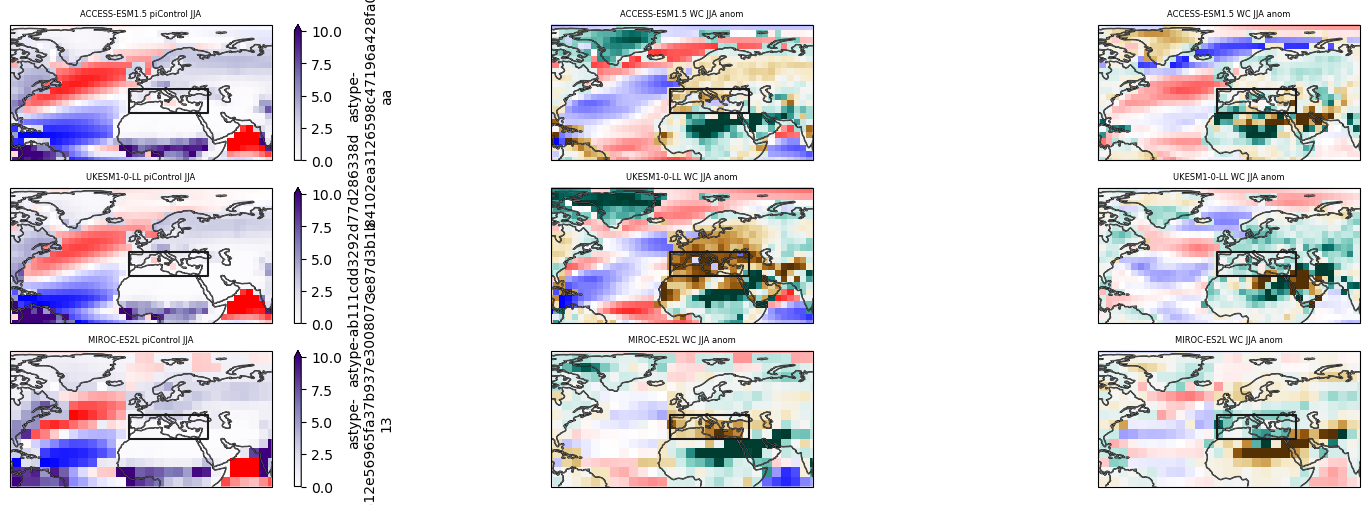

In [30]:
# 1000PgC Med

# ua data
concat_ua_warming_anom_annual_brch= concat_ua_warming_1000_anom
concat_ua_NZ_anom_annual_brch=concat_ua_NZ_1000_anom # these are piControl relative anoms

concat_ua_warming_anom_JJA_brch=concat_ua_warming_1000_anom_JJA
concat_ua_NZ_anom_JJA_brch = concat_ua_NZ_1000_anom_JJA

concat_ua_warming_anom_DJF_brch=concat_ua_warming_1000_anom_DJF
concat_ua_NZ_anom_DJF_brch=concat_ua_NZ_1000_anom_DJF

concat_ua_piControl=concat_ua_piControl


# tas data
concat_tas_warming_anom_annual_brch= concat_tas_warming_1000_anom
concat_tas_NZ_anom_annual_brch=concat_tas_NZ_1000_anom # these are piControl relative anoms

concat_tas_warming_anom_JJA_brch=concat_tas_warming_1000_anom_JJA
concat_tas_NZ_anom_JJA_brch = concat_tas_NZ_1000_anom_JJA

concat_tas_warming_anom_DJF_brch=concat_tas_warming_1000_anom_DJF
concat_tas_NZ_anom_DJF_brch=concat_tas_NZ_1000_anom_DJF

concat_tas_piControl=concat_tas_piControl


# pr data
concat_pr_warming_anom_annual_brch= concat_pr_warming_1000_anom
concat_pr_NZ_anom_annual_brch=concat_pr_NZ_1000_anom # these are piControl relative anoms

concat_pr_warming_anom_JJA_brch=concat_pr_warming_1000_anom_JJA
concat_pr_NZ_anom_JJA_brch = concat_pr_NZ_1000_anom_JJA

concat_pr_warming_anom_DJF_brch=concat_pr_warming_1000_anom_DJF
concat_pr_NZ_anom_DJF_brch=concat_pr_NZ_1000_anom_DJF

concat_pr_piControl=concat_pr_piControl


# Other args
branch_name="1000PgC"
model_list_str=model_str
concat_land_mask=land_mask_concat
deg_lat=5
deg_lon=5


lon_min=80
lon_max=275
lat_min=0
lat_max=60

set_extent_bool=True
region_name_save="W_Europe_medit"
deg_lat_list=deg_lat_list
region_nums=[19, 25, 26]

pr_sst_uwind_branch_grid_regrid_JJA(concat_ua_warming_anom_annual_brch, concat_ua_NZ_anom_annual_brch,
                             concat_ua_warming_anom_JJA_brch, concat_ua_NZ_anom_JJA_brch,
                             concat_ua_warming_anom_DJF_brch, concat_ua_NZ_anom_DJF_brch,
                             concat_ua_piControl,


                            concat_tas_warming_anom_annual_brch, concat_tas_NZ_anom_annual_brch,
                             concat_tas_warming_anom_JJA_brch, concat_tas_NZ_anom_JJA_brch,
                             concat_tas_warming_anom_DJF_brch, concat_tas_NZ_anom_DJF_brch,
                             concat_tas_piControl,


                             concat_pr_warming_anom_annual_brch, concat_pr_NZ_anom_annual_brch,
                             concat_pr_warming_anom_JJA_brch, concat_pr_NZ_anom_JJA_brch,
                             concat_pr_warming_anom_DJF_brch, concat_pr_NZ_anom_DJF_brch,
                             concat_pr_piControl,


                             branch_name, model_list_str, concat_land_mask, plev_850_list,
                               deg_lat, deg_lon,
                                   
                             lat_min, lat_max, lon_min, lon_max, set_extent_bool, region_name_save,
                                   deg_lat_list, region_nums)

ACCESS-ESM1.5


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, retu

UKESM1-0-LL


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, retu

MIROC-ES2L


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, retu

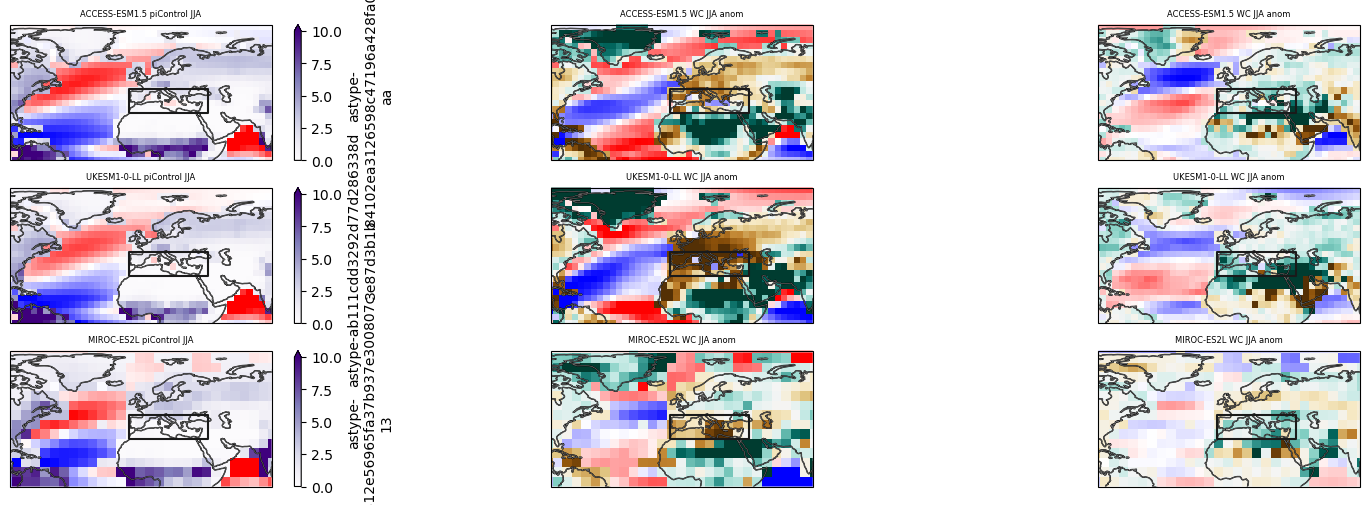

In [31]:
# 2000PgC Med

# ua data
concat_ua_warming_anom_annual_brch= concat_ua_warming_2000_anom
concat_ua_NZ_anom_annual_brch=concat_ua_NZ_2000_anom # these are piControl relative anoms

concat_ua_warming_anom_JJA_brch=concat_ua_warming_2000_anom_JJA
concat_ua_NZ_anom_JJA_brch = concat_ua_NZ_2000_anom_JJA

concat_ua_warming_anom_DJF_brch=concat_ua_warming_2000_anom_DJF
concat_ua_NZ_anom_DJF_brch=concat_ua_NZ_2000_anom_DJF

concat_ua_piControl=concat_ua_piControl


# tas data
concat_tas_warming_anom_annual_brch= concat_tas_warming_2000_anom
concat_tas_NZ_anom_annual_brch=concat_tas_NZ_2000_anom # these are piControl relative anoms

concat_tas_warming_anom_JJA_brch=concat_tas_warming_2000_anom_JJA
concat_tas_NZ_anom_JJA_brch = concat_tas_NZ_2000_anom_JJA

concat_tas_warming_anom_DJF_brch=concat_tas_warming_2000_anom_DJF
concat_tas_NZ_anom_DJF_brch=concat_tas_NZ_2000_anom_DJF

concat_tas_piControl=concat_tas_piControl


# pr data
concat_pr_warming_anom_annual_brch= concat_pr_warming_2000_anom
concat_pr_NZ_anom_annual_brch=concat_pr_NZ_2000_anom # these are piControl relative anoms

concat_pr_warming_anom_JJA_brch=concat_pr_warming_2000_anom_JJA
concat_pr_NZ_anom_JJA_brch = concat_pr_NZ_2000_anom_JJA

concat_pr_warming_anom_DJF_brch=concat_pr_warming_2000_anom_DJF
concat_pr_NZ_anom_DJF_brch=concat_pr_NZ_2000_anom_DJF

concat_pr_piControl=concat_pr_piControl


# Other args
branch_name="2000PgC"
model_list_str=model_str
concat_land_mask=land_mask_concat
deg_lat=2
deg_lon=2
region_nums=[19, 25, 26]

lon_min=80
lon_max=275
lat_min=0
lat_max=60

set_extent_bool=True
region_name_save="W_Europe_Medit"
deg_lat_list=deg_lat_list

pr_sst_uwind_branch_grid_regrid_JJA(concat_ua_warming_anom_annual_brch, concat_ua_NZ_anom_annual_brch,
                             concat_ua_warming_anom_JJA_brch, concat_ua_NZ_anom_JJA_brch,
                             concat_ua_warming_anom_DJF_brch, concat_ua_NZ_anom_DJF_brch,
                             concat_ua_piControl,


                            concat_tas_warming_anom_annual_brch, concat_tas_NZ_anom_annual_brch,
                             concat_tas_warming_anom_JJA_brch, concat_tas_NZ_anom_JJA_brch,
                             concat_tas_warming_anom_DJF_brch, concat_tas_NZ_anom_DJF_brch,
                             concat_tas_piControl,


                             concat_pr_warming_anom_annual_brch, concat_pr_NZ_anom_annual_brch,
                             concat_pr_warming_anom_JJA_brch, concat_pr_NZ_anom_JJA_brch,
                             concat_pr_warming_anom_DJF_brch, concat_pr_NZ_anom_DJF_brch,
                             concat_pr_piControl,


                             branch_name, model_list_str, concat_land_mask, plev_850_list,
                               deg_lat, deg_lon,
                                   
                             lat_min, lat_max, lon_min, lon_max, set_extent_bool, region_name_save,
                                   deg_lat_list, region_nums)


ACCESS-ESM1.5


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, retu

UKESM1-0-LL


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, retu

MIROC-ES2L


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, retu

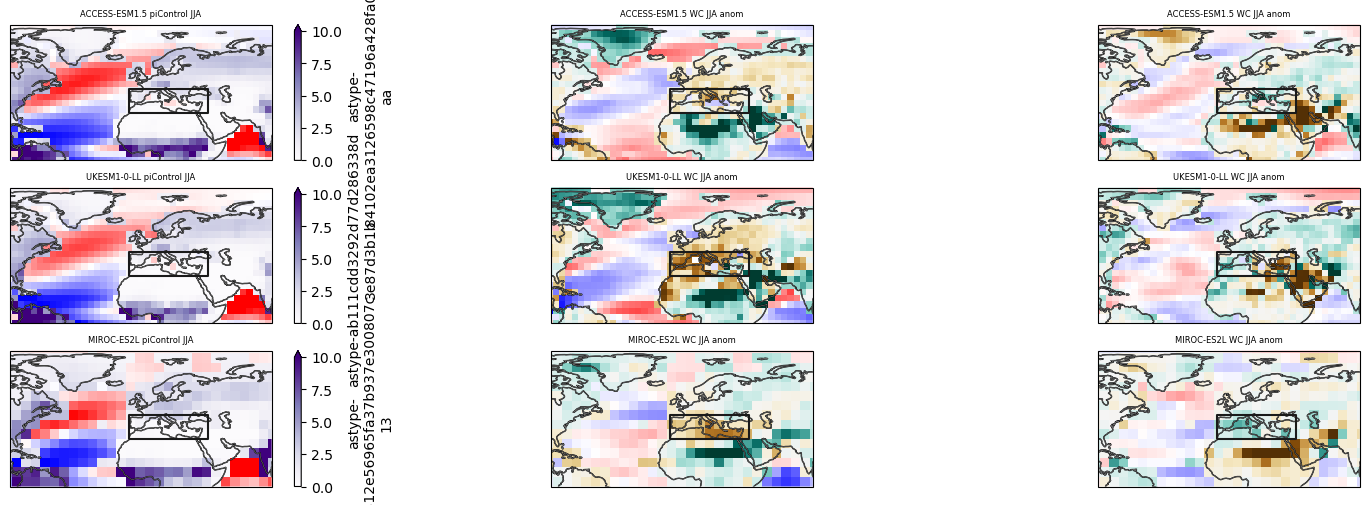

In [32]:
# 750PgC Med

# ua data
concat_ua_warming_anom_annual_brch= concat_ua_warming_750_anom
concat_ua_NZ_anom_annual_brch=concat_ua_NZ_750_anom # these are piControl relative anoms

concat_ua_warming_anom_JJA_brch=concat_ua_warming_750_anom_JJA
concat_ua_NZ_anom_JJA_brch = concat_ua_NZ_750_anom_JJA

concat_ua_warming_anom_DJF_brch=concat_ua_warming_750_anom_DJF
concat_ua_NZ_anom_DJF_brch=concat_ua_NZ_750_anom_DJF

concat_ua_piControl=concat_ua_piControl


# tas data
concat_tas_warming_anom_annual_brch= concat_tas_warming_750_anom
concat_tas_NZ_anom_annual_brch=concat_tas_NZ_750_anom # these are piControl relative anoms

concat_tas_warming_anom_JJA_brch=concat_tas_warming_750_anom_JJA
concat_tas_NZ_anom_JJA_brch = concat_tas_NZ_750_anom_JJA

concat_tas_warming_anom_DJF_brch=concat_tas_warming_750_anom_DJF
concat_tas_NZ_anom_DJF_brch=concat_tas_NZ_750_anom_DJF

concat_tas_piControl=concat_tas_piControl


# pr data
concat_pr_warming_anom_annual_brch= concat_pr_warming_750_anom
concat_pr_NZ_anom_annual_brch=concat_pr_NZ_750_anom # these are piControl relative anoms

concat_pr_warming_anom_JJA_brch=concat_pr_warming_750_anom_JJA
concat_pr_NZ_anom_JJA_brch = concat_pr_NZ_750_anom_JJA

concat_pr_warming_anom_DJF_brch=concat_pr_warming_750_anom_DJF
concat_pr_NZ_anom_DJF_brch=concat_pr_NZ_750_anom_DJF

concat_pr_piControl=concat_pr_piControl


# Other args
branch_name="750PgC"
model_list_str=model_str
concat_land_mask=land_mask_concat
deg_lat=2
deg_lon=2
region_nums=[19, 25, 26]

lon_min=80
lon_max=275
lat_min=0
lat_max=60

set_extent_bool=True
region_name_save="W_Europe_Medit"
deg_lat_list=deg_lat_list

pr_sst_uwind_branch_grid_regrid_JJA(concat_ua_warming_anom_annual_brch, concat_ua_NZ_anom_annual_brch,
                             concat_ua_warming_anom_JJA_brch, concat_ua_NZ_anom_JJA_brch,
                             concat_ua_warming_anom_DJF_brch, concat_ua_NZ_anom_DJF_brch,
                             concat_ua_piControl,


                            concat_tas_warming_anom_annual_brch, concat_tas_NZ_anom_annual_brch,
                             concat_tas_warming_anom_JJA_brch, concat_tas_NZ_anom_JJA_brch,
                             concat_tas_warming_anom_DJF_brch, concat_tas_NZ_anom_DJF_brch,
                             concat_tas_piControl,


                             concat_pr_warming_anom_annual_brch, concat_pr_NZ_anom_annual_brch,
                             concat_pr_warming_anom_JJA_brch, concat_pr_NZ_anom_JJA_brch,
                             concat_pr_warming_anom_DJF_brch, concat_pr_NZ_anom_DJF_brch,
                             concat_pr_piControl,


                             branch_name, model_list_str, concat_land_mask, plev_850_list,
                               deg_lat, deg_lon,
                                   
                             lat_min, lat_max, lon_min, lon_max, set_extent_bool, region_name_save,
                                   deg_lat_list, region_nums)


## DJF

In [33]:
def pr_sst_uwind_branch_grid_regrid_DJF(concat_ua_warming_anom_annual_brch, concat_ua_NZ_anom_annual_brch,
                             concat_ua_warming_anom_JJA_brch, concat_ua_NZ_anom_JJA_brch,
                             concat_ua_warming_anom_DJF_brch, concat_ua_NZ_anom_DJF_brch,
                             concat_ua_piControl,


                            concat_tas_warming_anom_annual_brch, concat_tas_NZ_anom_annual_brch,
                             concat_tas_warming_anom_JJA_brch, concat_tas_NZ_anom_JJA_brch,
                             concat_tas_warming_anom_DJF_brch, concat_tas_NZ_anom_DJF_brch,
                             concat_tas_piControl,


                             concat_pr_warming_anom_annual_brch, concat_pr_NZ_anom_annual_brch,
                             concat_pr_warming_anom_JJA_brch, concat_pr_NZ_anom_JJA_brch,
                             concat_pr_warming_anom_DJF_brch, concat_pr_NZ_anom_DJF_brch,
                             concat_pr_piControl,


                             branch_name, model_list_str, concat_land_mask, plev_850_list,
                                          deg_lat, deg_lon,
                                       
                            lat_min, lat_max, lon_min, lon_max, set_extent_bool, region_name_save,
                                       deg_lat_list, region_nums):

    """

    Plot out grid of surface pr, SST, and u wind 850hPa anomalies for single branch and 3 ESMs

    """

    # 3 ESMs, piControl, WC anomaly, NZ-WC anomaly
    # ---Annual first 2, DJF 2 two, JJA third 2
    nrows=3
    ncols=3

    # SSTs - Cmap, mins, max ---> this may not be used. Just going to do contours
    cmap_tas="bwr"
    tas_min = 0
    tas_max = 30

    
    # Precipitation over land - Cmap, mins, max
    cmap_pr = "Purples"
    cmap_NZ_minus_WC = "BrBG"
    pr_min = -30
    pr_max = 30

    ua_piControl_min = -10
    ua_piControl_max = 10

    ua_min = -1.5
    ua_max = 1.5
    

    # uas wind anomalies
    cmap_uas = "bwr"
    cmap_uas_NZ_minus_WC = "bwr"


    fig, axes = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=360)},
                        figsize=(20,6))


    # ---------------------------------PiControl calcs ---------------------------------------------

    # Annual plots
    col=0 

    for model in range(len(concat_ua_piControl)):
        
        # Looping through piControl data, computing SST, pr land, and ua
        print(model_list_str[model])

        
        tas_piControl_lat_lon=regridding_time_lat_lon_V1_tas_piControl(concat_tas_piControl[model], deg_lat_list[model], deg_lat_list[model])
        pr_piControl_lat_lon=regridding_time_lat_lon_V1_pr_piControl(concat_pr_piControl[model], deg_lat_list[model], deg_lat_list[model])
        ua_piControl_lat_lon=regridding_time_lat_lon_V1_ua_piControl(concat_ua_piControl[model].sel(plev=concat_ua_piControl[model].plev[plev_850_list[model]]), deg_lat_list[model], deg_lat_list[model])
        land_mask_data=regridding_lat_lon_land(concat_land_mask[model], deg_lat_list[model], deg_lat_list[model])
    
        #
        # --------------------------------- Temp data ocean ------------------------------------------
    
        tas_piControl_lat_lon_ocean = tas_piControl_lat_lon.groupby("time.season")["DJF"].where(land_mask_data==0)
        ua_piControl_lat_lon_ocean = ua_piControl_lat_lon.groupby("time.season")["DJF"].where(land_mask_data==0)
        pr_piControl_lat_lon_land = pr_piControl_lat_lon.groupby("time.season")["DJF"].where(land_mask_data!=0)
    
        
        tas_piControl_lat_lon_ocean=tas_piControl_lat_lon_ocean.resample(time="Y").mean(dim="time").mean(dim="time")
        ua_piControl_lat_lon_ocean=ua_piControl_lat_lon_ocean.resample(time="Y").mean(dim="time").mean(dim="time")
        pr_piControl_lat_lon_land=86400*pr_piControl_lat_lon_land.resample(time="Y").mean(dim="time").mean(dim="time")
    
        ua_plot=ua_piControl_lat_lon_ocean.plot(ax=axes[model, col],transform=ccrs.PlateCarree(),
                                                vmin=ua_piControl_min, vmax=ua_piControl_max,
                                      cmap=cmap_uas, add_colorbar=False)
    
        pr_plot=pr_piControl_lat_lon_land.plot(ax=axes[model, col],transform=ccrs.PlateCarree(),
                                      cmap=cmap_pr, add_colorbar=False)
    
        
        
        axes[model, col].coastlines()
    
        axes[model, col].set_title(model_list_str[model]+ " piControl DJF",
                                  fontsize=6)
        
        add_AR6_outline(region_nums, axes[model, col])

        if set_extent_bool==True:
            axes[model, col].set_extent([lon_min, lon_max, lat_min, lat_max])


    for model in range(len(concat_ua_piControl)):
        
        # ------------------------------------Warming climate anomaly-----------------------------------
        col=1
    
        tas_WC_lat_lon_anom=regridding_lat_lon_tas(concat_tas_warming_anom_DJF_brch[model], deg_lat_list[model], deg_lat_list[model])
        pr_WC_lat_lon_anom=regridding_lat_lon_pr(concat_pr_warming_anom_DJF_brch[model], deg_lat_list[model], deg_lat_list[model])
        ua_WC_lat_lon_anom=regridding_lat_lon_ua(concat_ua_warming_anom_DJF_brch[model], deg_lat_list[model], deg_lat_list[model])
        land_mask_data=regridding_lat_lon_land(concat_land_mask[model], deg_lat_list[model], deg_lat_list[model])
    
    
        # -masking land and ocean data
        tas_WC_lat_lon_anom = tas_WC_lat_lon_anom.where(land_mask_data==0)
        ua_WC_lat_lon_anom = ua_WC_lat_lon_anom.where(land_mask_data==0)
        pr_WC_lat_lon_anom = pr_WC_lat_lon_anom.where(land_mask_data!=0)
    
        ua_plot=ua_WC_lat_lon_anom.plot(ax=axes[model, col],transform=ccrs.PlateCarree(),
                                        vmin=ua_min, vmax=ua_max,
                                      cmap=cmap_uas_NZ_minus_WC, add_colorbar=False)
    
        pr_plot=pr_WC_lat_lon_anom.plot(ax=axes[model, col],transform=ccrs.PlateCarree(),
                                      cmap=cmap_NZ_minus_WC, add_colorbar=False,
                                       vmin=pr_min, vmax=pr_max)
    
        
        axes[model, col].coastlines()
    
        axes[model, col].set_title(model_list_str[model]+ " WC DJF anom",
                                  fontsize=6)

        add_AR6_outline(region_nums, axes[model, col])

        if set_extent_bool==True:
            axes[model, col].set_extent([lon_min, lon_max, lat_min, lat_max])


    for model in range(len(concat_ua_piControl)):
        
        # ------------------------------------NZ climate anomaly-----------------------------------
        col=2
        
        tas_WC_lat_lon_anom=regridding_lat_lon_tas(concat_tas_warming_anom_DJF_brch[model], deg_lat_list[model], deg_lat_list[model])
        pr_WC_lat_lon_anom=regridding_lat_lon_pr(concat_pr_warming_anom_DJF_brch[model], deg_lat_list[model], deg_lat_list[model])
        ua_WC_lat_lon_anom=regridding_lat_lon_ua(concat_ua_warming_anom_DJF_brch[model], deg_lat_list[model], deg_lat_list[model])
    
        tas_NZ_lat_lon_anom=regridding_lat_lon_tas(concat_tas_NZ_anom_DJF_brch[model], deg_lat_list[model], deg_lat_list[model])
        pr_NZ_lat_lon_anom=regridding_lat_lon_pr(concat_pr_NZ_anom_DJF_brch[model], deg_lat_list[model], deg_lat_list[model])
        ua_NZ_lat_lon_anom=regridding_lat_lon_ua(concat_ua_NZ_anom_DJF_brch[model], deg_lat_list[model], deg_lat_list[model])

        land_mask_data=regridding_lat_lon_land(concat_land_mask[model], deg_lat_list[model], deg_lat_list[model])
    
        # -masking land and ocean data
        tas_WC_lat_lon_anom = tas_WC_lat_lon_anom.where(land_mask_data==0)
        ua_WC_lat_lon_anom = ua_WC_lat_lon_anom.where(land_mask_data==0)
        pr_WC_lat_lon_anom = pr_WC_lat_lon_anom.where(land_mask_data!=0)
    
        tas_NZ_lat_lon_anom = tas_NZ_lat_lon_anom.where(land_mask_data==0)
        ua_NZ_lat_lon_anom = ua_NZ_lat_lon_anom.where(land_mask_data==0)
        pr_NZ_lat_lon_anom = pr_NZ_lat_lon_anom.where(land_mask_data!=0)
    
        tas_NZ_minus_WC_lat_lon_anom = tas_NZ_lat_lon_anom-tas_WC_lat_lon_anom
        pr_NZ_minus_WC_lat_lon_anom = pr_NZ_lat_lon_anom-pr_WC_lat_lon_anom
        ua_NZ_minus_WC_lat_lon_anom = ua_NZ_lat_lon_anom-ua_WC_lat_lon_anom
    
    
        ua_plot=ua_NZ_minus_WC_lat_lon_anom.plot(ax=axes[model, col],transform=ccrs.PlateCarree(),
                                                 vmin=ua_min, vmax=ua_max,
                                      cmap=cmap_uas_NZ_minus_WC, add_colorbar=False)
    
        pr_plot=pr_NZ_minus_WC_lat_lon_anom.plot(ax=axes[model, col],transform=ccrs.PlateCarree(),
                                      cmap=cmap_NZ_minus_WC, add_colorbar=False,
                                       vmin=pr_min, vmax=pr_max)
    
        
        axes[model, col].coastlines()
    
        axes[model, col].set_title(model_list_str[model]+ " WC DJF anom",
                                  fontsize=6)

        add_AR6_outline(region_nums, axes[model, col])

        if set_extent_bool==True:
            axes[model, col].set_extent([lon_min, lon_max, lat_min, lat_max])


    plt.savefig("/g/data/ob22/lc6551/SSP126_extended/ZECMIP_driv_figs/pr_wind_plots_DJF_setext_" + region_name_save + "_" + branch_name + ".png")

            
    
        

ACCESS-ESM1.5


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, retu

UKESM1-0-LL


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, retu

MIROC-ES2L


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, retu

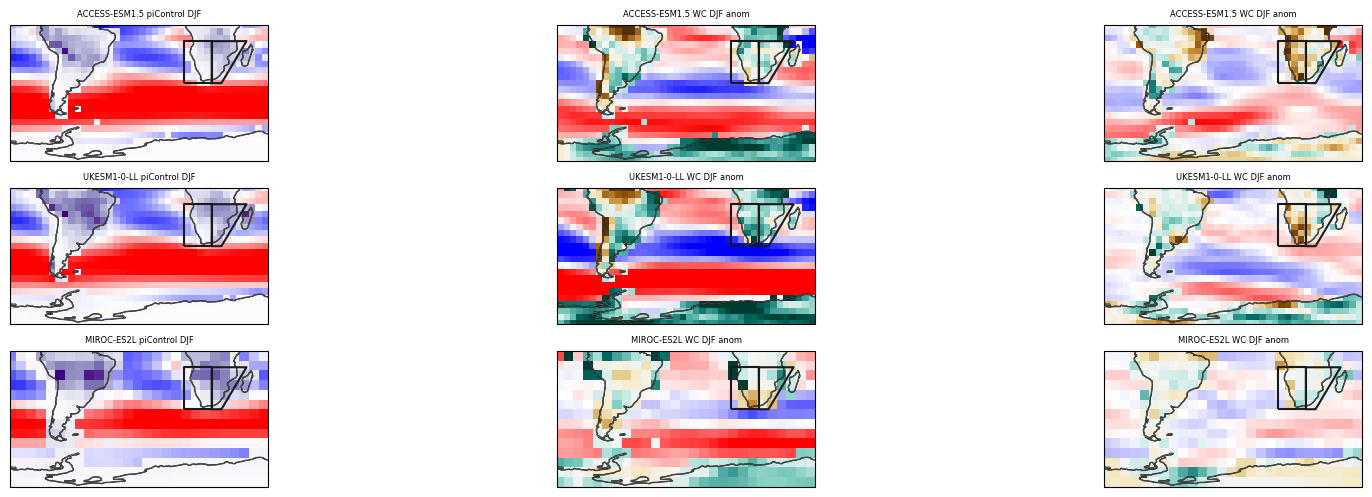

In [34]:
# 1000PgC SAF

# ua data
concat_ua_warming_anom_annual_brch= concat_ua_warming_1000_anom
concat_ua_NZ_anom_annual_brch=concat_ua_NZ_1000_anom # these are piControl relative anoms

concat_ua_warming_anom_JJA_brch=concat_ua_warming_1000_anom_JJA
concat_ua_NZ_anom_JJA_brch = concat_ua_NZ_1000_anom_JJA

concat_ua_warming_anom_DJF_brch=concat_ua_warming_1000_anom_DJF
concat_ua_NZ_anom_DJF_brch=concat_ua_NZ_1000_anom_DJF

concat_ua_piControl=concat_ua_piControl


# tas data
concat_tas_warming_anom_annual_brch= concat_tas_warming_1000_anom
concat_tas_NZ_anom_annual_brch=concat_tas_NZ_1000_anom # these are piControl relative anoms

concat_tas_warming_anom_JJA_brch=concat_tas_warming_1000_anom_JJA
concat_tas_NZ_anom_JJA_brch = concat_tas_NZ_1000_anom_JJA

concat_tas_warming_anom_DJF_brch=concat_tas_warming_1000_anom_DJF
concat_tas_NZ_anom_DJF_brch=concat_tas_NZ_1000_anom_DJF

concat_tas_piControl=concat_tas_piControl


# pr data
concat_pr_warming_anom_annual_brch= concat_pr_warming_1000_anom
concat_pr_NZ_anom_annual_brch=concat_pr_NZ_1000_anom # these are piControl relative anoms

concat_pr_warming_anom_JJA_brch=concat_pr_warming_1000_anom_JJA
concat_pr_NZ_anom_JJA_brch = concat_pr_NZ_1000_anom_JJA

concat_pr_warming_anom_DJF_brch=concat_pr_warming_1000_anom_DJF
concat_pr_NZ_anom_DJF_brch=concat_pr_NZ_1000_anom_DJF

concat_pr_piControl=concat_pr_piControl

region_name_save="Southern_Africa"

# Other args
branch_name="1000PgC"
model_list_str=model_str
concat_land_mask=land_mask_concat
deg_lat=2
deg_lon=2
deg_lat_list=deg_lat_list
region_nums=[19, 25, 26]

# Southern Africa
lon_min=60
lon_max=260
lat_min=-60 
lat_max=0

set_extent_bool=True


pr_sst_uwind_branch_grid_regrid_DJF(concat_ua_warming_anom_annual_brch, concat_ua_NZ_anom_annual_brch,
                             concat_ua_warming_anom_JJA_brch, concat_ua_NZ_anom_JJA_brch,
                             concat_ua_warming_anom_DJF_brch, concat_ua_NZ_anom_DJF_brch,
                             concat_ua_piControl,


                            concat_tas_warming_anom_annual_brch, concat_tas_NZ_anom_annual_brch,
                             concat_tas_warming_anom_JJA_brch, concat_tas_NZ_anom_JJA_brch,
                             concat_tas_warming_anom_DJF_brch, concat_tas_NZ_anom_DJF_brch,
                             concat_tas_piControl,


                             concat_pr_warming_anom_annual_brch, concat_pr_NZ_anom_annual_brch,
                             concat_pr_warming_anom_JJA_brch, concat_pr_NZ_anom_JJA_brch,
                             concat_pr_warming_anom_DJF_brch, concat_pr_NZ_anom_DJF_brch,
                             concat_pr_piControl,


                             branch_name, model_list_str, concat_land_mask, plev_850_list,
                               deg_lat, deg_lon,
                                   
                                   
                             lat_min, lat_max, lon_min, lon_max, set_extent_bool, region_name_save,
                                   deg_lat_list, region_nums=region_nums)

ACCESS-ESM1.5


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, retu

UKESM1-0-LL


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, retu

MIROC-ES2L


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, retu

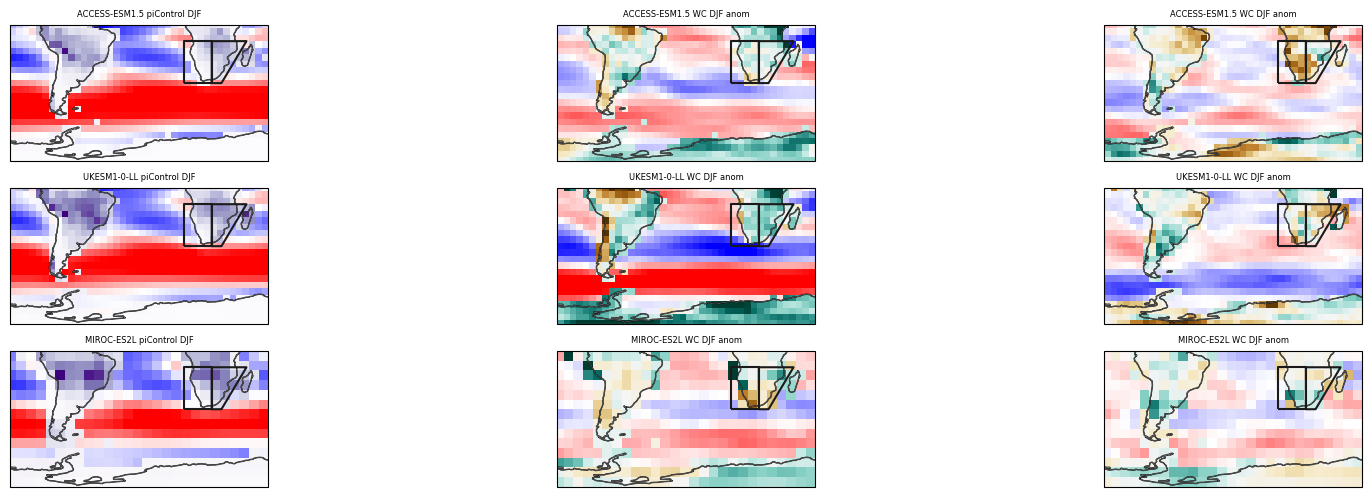

In [35]:
# 2000PgC SAF

# ua data
concat_ua_warming_anom_annual_brch= concat_ua_warming_750_anom
concat_ua_NZ_anom_annual_brch=concat_ua_NZ_750_anom # these are piControl relative anoms

concat_ua_warming_anom_JJA_brch=concat_ua_warming_750_anom_JJA
concat_ua_NZ_anom_JJA_brch = concat_ua_NZ_750_anom_JJA

concat_ua_warming_anom_DJF_brch=concat_ua_warming_750_anom_DJF
concat_ua_NZ_anom_DJF_brch=concat_ua_NZ_750_anom_DJF

concat_ua_piControl=concat_ua_piControl


# tas data
concat_tas_warming_anom_annual_brch= concat_tas_warming_750_anom
concat_tas_NZ_anom_annual_brch=concat_tas_NZ_750_anom # these are piControl relative anoms

concat_tas_warming_anom_JJA_brch=concat_tas_warming_750_anom_JJA
concat_tas_NZ_anom_JJA_brch = concat_tas_NZ_750_anom_JJA

concat_tas_warming_anom_DJF_brch=concat_tas_warming_750_anom_DJF
concat_tas_NZ_anom_DJF_brch=concat_tas_NZ_750_anom_DJF

concat_tas_piControl=concat_tas_piControl


# pr data
concat_pr_warming_anom_annual_brch= concat_pr_warming_750_anom
concat_pr_NZ_anom_annual_brch=concat_pr_NZ_750_anom # these are piControl relative anoms

concat_pr_warming_anom_JJA_brch=concat_pr_warming_750_anom_JJA
concat_pr_NZ_anom_JJA_brch = concat_pr_NZ_750_anom_JJA

concat_pr_warming_anom_DJF_brch=concat_pr_warming_750_anom_DJF
concat_pr_NZ_anom_DJF_brch=concat_pr_NZ_750_anom_DJF

concat_pr_piControl=concat_pr_piControl


# Other args
branch_name="750PgC"
model_list_str=model_str
concat_land_mask=land_mask_concat
deg_lat=2
deg_lon=2
deg_lat_list=deg_lat_list
region_nums=[19, 25, 26]

# Southern Africa
lon_min=60
lon_max=260
lat_min=-60 
lat_max=0

set_extent_bool=True
region_name_save="Southern_Africa"

pr_sst_uwind_branch_grid_regrid_DJF(concat_ua_warming_anom_annual_brch, concat_ua_NZ_anom_annual_brch,
                             concat_ua_warming_anom_JJA_brch, concat_ua_NZ_anom_JJA_brch,
                             concat_ua_warming_anom_DJF_brch, concat_ua_NZ_anom_DJF_brch,
                             concat_ua_piControl,


                            concat_tas_warming_anom_annual_brch, concat_tas_NZ_anom_annual_brch,
                             concat_tas_warming_anom_JJA_brch, concat_tas_NZ_anom_JJA_brch,
                             concat_tas_warming_anom_DJF_brch, concat_tas_NZ_anom_DJF_brch,
                             concat_tas_piControl,


                             concat_pr_warming_anom_annual_brch, concat_pr_NZ_anom_annual_brch,
                             concat_pr_warming_anom_JJA_brch, concat_pr_NZ_anom_JJA_brch,
                             concat_pr_warming_anom_DJF_brch, concat_pr_NZ_anom_DJF_brch,
                             concat_pr_piControl,


                             branch_name, model_list_str, concat_land_mask, plev_850_list,
                               deg_lat, deg_lon,
                                   
                                   
                             lat_min, lat_max, lon_min, lon_max, set_extent_bool, region_name_save,
                                   deg_lat_list, region_nums=region_nums)


ACCESS-ESM1.5


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, retu

UKESM1-0-LL


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, retu

MIROC-ES2L


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, retu

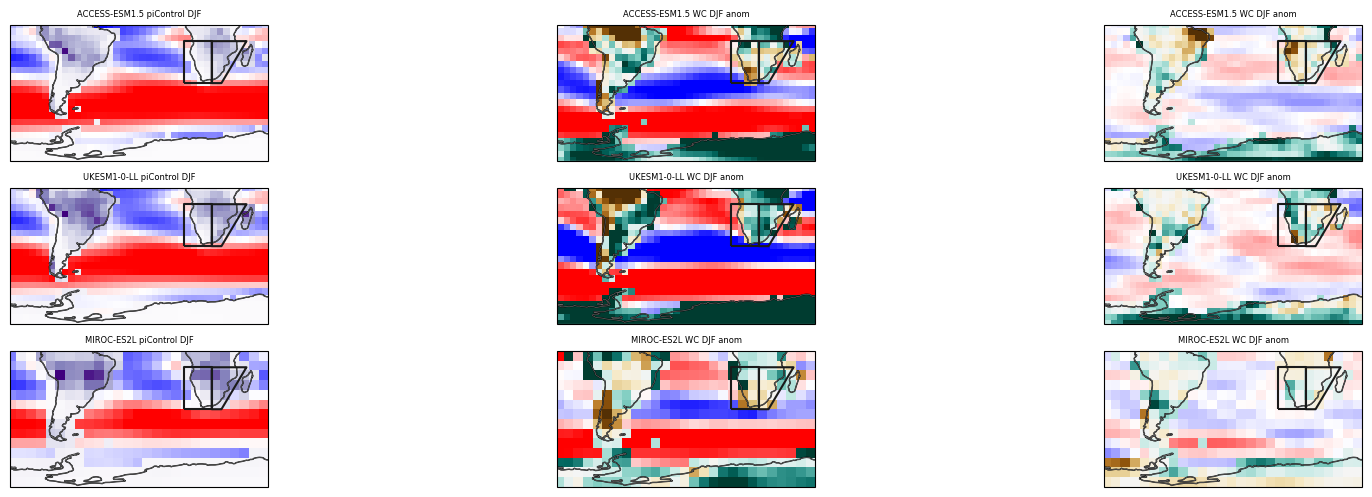

In [36]:
# 750PgC SAF

# ua data
concat_ua_warming_anom_annual_brch= concat_ua_warming_2000_anom
concat_ua_NZ_anom_annual_brch=concat_ua_NZ_2000_anom # these are piControl relative anoms

concat_ua_warming_anom_JJA_brch=concat_ua_warming_2000_anom_JJA
concat_ua_NZ_anom_JJA_brch = concat_ua_NZ_2000_anom_JJA

concat_ua_warming_anom_DJF_brch=concat_ua_warming_2000_anom_DJF
concat_ua_NZ_anom_DJF_brch=concat_ua_NZ_2000_anom_DJF

concat_ua_piControl=concat_ua_piControl


# tas data
concat_tas_warming_anom_annual_brch= concat_tas_warming_2000_anom
concat_tas_NZ_anom_annual_brch=concat_tas_NZ_2000_anom # these are piControl relative anoms

concat_tas_warming_anom_JJA_brch=concat_tas_warming_2000_anom_JJA
concat_tas_NZ_anom_JJA_brch = concat_tas_NZ_2000_anom_JJA

concat_tas_warming_anom_DJF_brch=concat_tas_warming_2000_anom_DJF
concat_tas_NZ_anom_DJF_brch=concat_tas_NZ_2000_anom_DJF

concat_tas_piControl=concat_tas_piControl


# pr data
concat_pr_warming_anom_annual_brch= concat_pr_warming_2000_anom
concat_pr_NZ_anom_annual_brch=concat_pr_NZ_2000_anom # these are piControl relative anoms

concat_pr_warming_anom_JJA_brch=concat_pr_warming_2000_anom_JJA
concat_pr_NZ_anom_JJA_brch = concat_pr_NZ_2000_anom_JJA

concat_pr_warming_anom_DJF_brch=concat_pr_warming_2000_anom_DJF
concat_pr_NZ_anom_DJF_brch=concat_pr_NZ_2000_anom_DJF

concat_pr_piControl=concat_pr_piControl

region_nums=[19, 25, 26]
# Other args
branch_name="2000PgC"
model_list_str=model_str
concat_land_mask=land_mask_concat
deg_lat=2
deg_lon=2
deg_lat_list=deg_lat_list
region_name_save="Southern_Africa"

# Southern Africa
lon_min=60
lon_max=260
lat_min=-60 
lat_max=0

set_extent_bool=True


pr_sst_uwind_branch_grid_regrid_DJF(concat_ua_warming_anom_annual_brch, concat_ua_NZ_anom_annual_brch,
                             concat_ua_warming_anom_JJA_brch, concat_ua_NZ_anom_JJA_brch,
                             concat_ua_warming_anom_DJF_brch, concat_ua_NZ_anom_DJF_brch,
                             concat_ua_piControl,


                            concat_tas_warming_anom_annual_brch, concat_tas_NZ_anom_annual_brch,
                             concat_tas_warming_anom_JJA_brch, concat_tas_NZ_anom_JJA_brch,
                             concat_tas_warming_anom_DJF_brch, concat_tas_NZ_anom_DJF_brch,
                             concat_tas_piControl,


                             concat_pr_warming_anom_annual_brch, concat_pr_NZ_anom_annual_brch,
                             concat_pr_warming_anom_JJA_brch, concat_pr_NZ_anom_JJA_brch,
                             concat_pr_warming_anom_DJF_brch, concat_pr_NZ_anom_DJF_brch,
                             concat_pr_piControl,


                             branch_name, model_list_str, concat_land_mask, plev_850_list,
                               deg_lat, deg_lon,
                                   
                                   
                             lat_min, lat_max, lon_min, lon_max, set_extent_bool, region_name_save,
                                   deg_lat_list, region_nums=region_nums)
